# simple synthetic inversion

Here we try to recover the true Layer 1 topography with a gravity inversion. We start with the forward gravity of Layer 1 as the observed gravity, then down-sample this gravity to represent a coarser gravity survey, and final, repeate these steps with a regional component including in the observed gravity. The regional component is the forward gravity of Layer 2. 

We also explore adding gaussian noise to these gravity data. 

The starting (low-resolution) Layer 1 topography has been created through the random sampling and gridding of 30 points. In an Antarctic setting, these points represent single seismic survey locations which measure the elevation of Layer 1. 

import packages

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext snakeviz

import sys

from RIS_gravity_inversion import plotting, optimization, synthetic, regional
import RIS_gravity_inversion.inversion as inv
import RIS_gravity_inversion.utils as inv_utils

import copy
from antarctic_plots import utils, regions, maps, fetch, profile
import zarr
import harmonica as hm
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import verde as vd
import scipy as sp
import pvxarray
import rioxarray
import pygmt
import plotly.graph_objects as go
import optuna
from optuna.storages import JournalStorage, JournalFileStorage
import warnings
import os
import pathlib
import string

# Load data

## topographic layers
* 2 full resolution synthetic layers
* low resolution layer 2

In [2]:
layer1 = xr.open_zarr("../synthetic_data/synthetic_layer1.zarr").z

layer2 = xr.open_zarr("../synthetic_data/synthetic_layer2.zarr").z

starting_layer1 = xr.open_zarr("../synthetic_data/synthetic_lowres_layer1.zarr").z

# ensure all xarray are same data type
layer1 = layer1.astype(np.float64)
layer2 = layer2.astype(np.float64)
starting_layer1 = starting_layer1.astype(np.float64)

print(utils.get_grid_info(layer1))
print(utils.get_grid_info(layer2))
print(utils.get_grid_info(starting_layer1))
starting_layer1

/home/tankerma/miniconda/envs/RIS_gravity_inversion/lib/python3.10/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


(1000.0, [-6000.0, 86000.0, -6000.0, 66000.0], -952.152099609, -481.448486328, 'g')
(1000.0, [-6000.0, 86000.0, -6000.0, 66000.0], -4689.66455078, -3614.13256836, 'g')
(1000.0, [-6000.0, 86000.0, -6000.0, 66000.0], -941.945495605, -430.007873535, 'g')


<xarray.DataArray 'z' (northing: 73, easting: 93)>
dask.array<open_dataset-5f77f54453cc56c3605ecef2a0f1885az, shape=(73, 93), dtype=float64, chunksize=(73, 93), chunktype=numpy.ndarray>
Coordinates:
  * easting   (easting) float64 -6e+03 -5e+03 -4e+03 ... 8.4e+04 8.5e+04 8.6e+04
  * northing  (northing) float64 -6e+03 -5e+03 -4e+03 ... 6.5e+04 6.6e+04
Attributes:
    metadata:  Generated by Spline()

## gravity data
* full resolution forward gravity of Layer 1
* full resolution with regional component
* sampled forward gravity of Layer 1
* sampled with regional component

In [3]:
# full resolution gravity point data
grav = pd.read_csv(
    "../synthetic_data/synthetic_simple_full_res_gravity.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

# sampled gravity point data
sampled_grav = pd.read_csv(
    "../synthetic_data/synthetic_simple_sampled_gravity.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)
# sampled gravity point data
sampled_grav_with_reg = pd.read_csv(
    "../synthetic_data/synthetic_simple_with_regional_sampled_gravity.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

In [4]:
grav

northing  easting  Surface1  Surface2  forward_total  upward
0          0.0      0.0  4.895946 -1.585934       3.310012  1000.0
1          0.0   1000.0  4.764286 -1.697236       3.067050  1000.0
2          0.0   2000.0  4.616825 -1.806994       2.809832  1000.0
3          0.0   3000.0  4.458949 -1.915200       2.543749  1000.0
4          0.0   4000.0  4.294071 -2.021884       2.272188  1000.0
...        ...      ...       ...       ...            ...     ...
4936   60000.0  76000.0  0.829439  8.586936       9.416375  1000.0
4937   60000.0  77000.0  0.825047  8.508668       9.333715  1000.0
4938   60000.0  78000.0  0.822520  8.397605       9.220126  1000.0
4939   60000.0  79000.0  0.821311  8.246703       9.068014  1000.0
4940   60000.0  80000.0  0.820536  8.046806       8.867341  1000.0

[4941 rows x 6 columns]

In [5]:
sampled_grav

northing  easting  upward      Gobs
0          0.0      0.0  1000.0  4.895946
1          0.0   2000.0  1000.0  4.616826
2          0.0   4000.0  1000.0  4.294071
3          0.0   6000.0  1000.0  3.951658
4          0.0   8000.0  1000.0  3.600639
...        ...      ...     ...       ...
1266   60000.0  72000.0  1000.0  0.871080
1267   60000.0  74000.0  1000.0  0.845094
1268   60000.0  76000.0  1000.0  0.829439
1269   60000.0  78000.0  1000.0  0.822520
1270   60000.0  80000.0  1000.0  0.820536

[1271 rows x 4 columns]

In [6]:
sampled_grav_with_reg

northing  easting  upward      Gobs
0          0.0      0.0  1000.0  3.310012
1          0.0   2000.0  1000.0  2.809832
2          0.0   4000.0  1000.0  2.272187
3          0.0   6000.0  1000.0  1.720770
4          0.0   8000.0  1000.0  1.166181
...        ...      ...     ...       ...
1266   60000.0  72000.0  1000.0  9.534210
1267   60000.0  74000.0  1000.0  9.510522
1268   60000.0  76000.0  1000.0  9.416374
1269   60000.0  78000.0  1000.0  9.220125
1270   60000.0  80000.0  1000.0  8.867341

[1271 rows x 4 columns]

# Set region and parameters

Use the same regions and parameters as `synthetic_model_2layer.ipynb`

In [7]:
layer_spacing, buffer_region, _, _, registration = utils.get_grid_info(layer2)

# set gravity observation parameters
grav_observation_height = 1e3
grav_spacing = 1e3
sampled_grav_spacing = 2e3

inversion_region = utils.alter_region(
    buffer_region,
    zoom=6e3,
)[0]

# set density contrast
density = 2300 - 1024

print(f"spacing: {layer_spacing}m")
print(f"registration: {registration}")
print("inversion region = ", inversion_region)
print("buffer region = ", buffer_region)

spacing: 1000.0m
registration: g
inversion region =  [0.0, 80000.0, 0.0, 60000.0]
buffer region =  [-6000.0, 86000.0, -6000.0, 66000.0]


# Prep data

## grav data

In [8]:
full_res_grav = inv_utils.prep_grav_data(
    grav,
    region=inversion_region,
    input_grav_name="Surface1",
    input_coord_names=("easting", "northing", "upward"),
)
full_res_grav_with_reg = inv_utils.prep_grav_data(
    grav,
    region=inversion_region,
    input_grav_name="forward_total",
    input_coord_names=("easting", "northing", "upward"),
)
sampled_grav = inv_utils.prep_grav_data(
    sampled_grav,
    region=inversion_region,
    input_grav_name="Gobs",
    input_coord_names=("easting", "northing", "upward"),
)
sampled_grav_with_reg = inv_utils.prep_grav_data(
    sampled_grav_with_reg,
    region=inversion_region,
    input_grav_name="Gobs",
    input_coord_names=("easting", "northing", "upward"),
)

print(f"full resolution gravity: {len(full_res_grav)} points")
print(f"sampled gravity: {len(sampled_grav)} points")

print(f"gravity avg. elevation: {int(np.nanmean(full_res_grav.upward))}")

full resolution gravity: 4941 points
sampled gravity: 1271 points
gravity avg. elevation: 1000


## constraint points

In [9]:
# load constraint points into a dataframe
constraint_points_all = pd.read_csv(
    "../synthetic_data/synthetic_constraints.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

# ensure all points are within inversion region
constraint_points = utils.points_inside_region(
    constraint_points_all, inversion_region, names=("easting", "northing")
)

print(f"bathymetry control points:{len(constraint_points)}")
constraint_points.head()

bathymetry control points:30


easting      northing      upward
0  33361.760376   5900.810030 -728.101857
1  57625.959475  25266.457500 -703.361847
2      9.149985  57473.371809 -533.972411
3  24186.605811  31989.917098 -715.684441
4  11740.471265  41512.626837 -703.378641

## plot inputs

In [ ]:
# # grid the observed gravity
# Gobs = full_res_grav_with_reg.set_index(["northing", "easting"]).to_xarray().Gobs

# # plot observed gravity
# fig = maps.plot_grd(
#     grid=Gobs,
#     fig_height=8,
#     cmap="vik",
#     region=buffer_region,
#     title="Gravity anomaly",
#     cbar_unit="mGal",
#     show_region=inversion_region,
#     hist=True,
#     cbar_yoffset=3,
# )
# fig.text(
#     position="TL",
#     justify="BL",
#     text="a)",
#     font="26p,Helvetica,black",
#     offset="j0/.3",
#     no_clip=True,
# )

# # plot layer 1
# fig = maps.plot_grd(
#     grid=starting_layer1,
#     fig_height=8,
#     cmap="rain",
#     reverse_cpt=True,
#     region=buffer_region,
#     grd2cpt=True,
#     title="Starting Layer 1",
#     cbar_label="elevation",
#     cbar_unit="m",
#     show_region=inversion_region,
#     hist=True,
#     cbar_yoffset=3,
#     fig=fig,
#     origin_shift="xshift",
#     points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
#     points_style="c0.1c",
# )
# fig.text(
#     position="TL",
#     justify="BL",
#     text="b)",
#     font="26p,Helvetica,black",
#     offset="j0/.3",
#     no_clip=True,
# )

# # plot layer 2
# fig = maps.plot_grd(
#     grid=layer2,
#     fig_height=8,
#     cmap="rain",
#     reverse_cpt=True,
#     region=buffer_region,
#     grd2cpt=True,
#     title="Layer 2",
#     cbar_label="elevation",
#     cbar_unit="m",
#     show_region=inversion_region,
#     hist=True,
#     cbar_yoffset=3,
#     fig=fig,
#     origin_shift="xshift",
# )
# fig.text(
#     position="TL",
#     justify="BL",
#     text="c)",
#     font="26p,Helvetica,black",
#     offset="j0/.3",
#     no_clip=True,
# )

# fig.show()

In [ ]:
# # grid the observed gravity
# Gobs = full_res_grav.set_index(["northing", "easting"]).to_xarray().Gobs

# # plot observed gravity
# fig = maps.plot_grd(
#     grid=Gobs,
#     fig_height=8,
#     cmap="vik",
#     region=buffer_region,
#     title="Gravity anomaly",
#     cbar_unit="mGal",
#     show_region=inversion_region,
#     hist=True,
#     cbar_yoffset=3,
# )
# fig.text(
#     position="TL",
#     justify="BL",
#     text="a)",
#     font="26p,Helvetica,black",
#     offset="j0/.3",
#     no_clip=True,
# )

# # plot layer 1
# fig = maps.plot_grd(
#     grid=starting_layer1,
#     fig_height=8,
#     cmap="rain",
#     reverse_cpt=True,
#     region=buffer_region,
#     grd2cpt=True,
#     title="Starting Layer 1",
#     cbar_label="elevation",
#     cbar_unit="m",
#     show_region=inversion_region,
#     hist=True,
#     cbar_yoffset=3,
#     fig=fig,
#     origin_shift="xshift",
#     points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
#     points_style="c0.1c",
# )
# fig.text(
#     position="TL",
#     justify="BL",
#     text="b)",
#     font="26p,Helvetica,black",
#     offset="j0/.3",
#     no_clip=True,
# )

# fig.show()

# Gravity misfit

The `gravity misfit` is defined as the difference between the observed and predicted gravity:

$G_{misfit} = G_{obs} - G_{forward}$ 

To determine $G_{misfit}$, we need to forward model the gravitational effect of the starting Layer 1 density contrast. This will be the input into our inversion.


## layer 1 prisms

In [10]:
# create prisms around starting layer 1
# positive densities above reference, negative below
print(f"Layer 1 density contrast: {density}kgm-3")

layer1_prisms = inv_utils.grids_to_prisms(
    surface=starting_layer1,
    reference=starting_layer1.values.mean(),
    density=xr.where(
        starting_layer1 >= starting_layer1.values.mean(), density, -density),
)

# plotting.show_prism_layers(
#     [layer1_prisms],
#     cmap="viridis",
#     color_by="density",
#     # color_by="thickness",
#     zscale=100,
#     clip_box=False,
#     log_scale=False,
# )

Layer 1 density contrast: 1276kgm-3


## layer 1 gravity

In [11]:
# calculate gravity of layer1
layer1_grav_grid, layer1_grav_df = inv_utils.forward_grav_of_prismlayer(
    [layer1_prisms],
    full_res_grav,
    names=["layer1_prisms"],
    remove_median=False,
    progressbar=True,
    plot=False,
)

full_res_grav["layer1_forward"] = layer1_grav_df.forward_total
full_res_grav_with_reg["layer1_forward"] = layer1_grav_df.forward_total

full_res_grav

  0%|                                                  | 0/4941 [00:00<?, ?it/s]

northing  easting      Gobs  Surface2  forward_total  upward  \
0          0.0      0.0  4.895946 -1.585934       3.310012  1000.0   
1          0.0   1000.0  4.764286 -1.697236       3.067050  1000.0   
2          0.0   2000.0  4.616825 -1.806994       2.809832  1000.0   
3          0.0   3000.0  4.458949 -1.915200       2.543749  1000.0   
4          0.0   4000.0  4.294071 -2.021884       2.272188  1000.0   
...        ...      ...       ...       ...            ...     ...   
4936   60000.0  76000.0  0.829439  8.586936       9.416375  1000.0   
4937   60000.0  77000.0  0.825047  8.508668       9.333715  1000.0   
4938   60000.0  78000.0  0.822520  8.397605       9.220126  1000.0   
4939   60000.0  79000.0  0.821311  8.246703       9.068014  1000.0   
4940   60000.0  80000.0  0.820536  8.046806       8.867341  1000.0   

      layer1_forward  
0           6.004718  
1           5.751148  
2           5.492230  
3           5.235439  
4           4.984941  
...              ...  
4936        1.247832  
4937        1.338739  
4938        1.432526  
4939        1.528039  
4940        1.623114  

[4941 rows x 7 columns]

In [12]:
# repeat with sampled gravity
layer1_sampled_grav_grid, layer1_sampled_grav_df = inv_utils.forward_grav_of_prismlayer(
    [layer1_prisms],
    sampled_grav,
    names=["layer1_prisms"],
    remove_median=False,
    progressbar=True,
    plot=False,
)

sampled_grav["layer1_forward"] = layer1_sampled_grav_df.forward_total
sampled_grav_with_reg["layer1_forward"] = layer1_sampled_grav_df.forward_total

sampled_grav

  0%|                                                  | 0/1271 [00:00<?, ?it/s]

northing  easting  upward      Gobs  layer1_forward
0          0.0      0.0  1000.0  4.895946        6.004718
1          0.0   2000.0  1000.0  4.616826        5.492230
2          0.0   4000.0  1000.0  4.294071        4.984941
3          0.0   6000.0  1000.0  3.951658        4.509673
4          0.0   8000.0  1000.0  3.600639        4.069375
...        ...      ...     ...       ...             ...
1266   60000.0  72000.0  1000.0  0.871080        0.918792
1267   60000.0  74000.0  1000.0  0.845094        1.076428
1268   60000.0  76000.0  1000.0  0.829439        1.247832
1269   60000.0  78000.0  1000.0  0.822520        1.432526
1270   60000.0  80000.0  1000.0  0.820536        1.623114

[1271 rows x 5 columns]

## Misfit

In [13]:
full_res_grav = inv.misfit(
    input_grav=full_res_grav,
    input_forward_column="layer1_forward",
    input_grav_column="Gobs",
    constraints=constraint_points,
)
full_res_grav_with_reg = inv.misfit(
    input_grav=full_res_grav_with_reg,
    input_forward_column="layer1_forward",
    input_grav_column="Gobs",
    constraints=constraint_points,
)
sampled_grav = inv.misfit(
    input_grav=sampled_grav,
    input_forward_column="layer1_forward",
    input_grav_column="Gobs",
    constraints=constraint_points,
)
sampled_grav_with_reg = inv.misfit(
    input_grav=sampled_grav_with_reg,
    input_forward_column="layer1_forward",
    input_grav_column="Gobs",
    constraints=constraint_points,
)

DC shifted observed gravity by -0.43mGal to match forward gravity.
DC shifted observed gravity by -1.7mGal to match forward gravity.
DC shifted observed gravity by -0.43mGal to match forward gravity.
DC shifted observed gravity by -1.7mGal to match forward gravity.


### Save and load results

In [14]:
full_res_grav.to_csv(
    "../synthetic_data/synthetic_simple_starting_model_forward_gravity.csv.gz",
    sep=",",
    na_rep="",
    header=True,
    index=False,
    encoding="utf-8",
    compression="gzip",
)
full_res_grav_with_reg.to_csv(
    "../synthetic_data/synthetic_simple_with_reg_starting_model_forward_gravity.csv.gz",
    sep=",",
    na_rep="",
    header=True,
    index=False,
    encoding="utf-8",
    compression="gzip",
)
sampled_grav.to_csv(
    "../synthetic_data/synthetic_simple_sampled_starting_model_forward_gravity.csv.gz",
    sep=",",
    na_rep="",
    header=True,
    index=False,
    encoding="utf-8",
    compression="gzip",
)
sampled_grav_with_reg.to_csv(
    "../synthetic_data/synthetic_simple_sampled_with_reg_starting_model_forward_gravity.csv.gz",
    sep=",",
    na_rep="",
    header=True,
    index=False,
    encoding="utf-8",
    compression="gzip",
)

In [15]:
full_res_grav = pd.read_csv(
    "../synthetic_data/synthetic_simple_starting_model_forward_gravity.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)
full_res_grav_with_reg = pd.read_csv(
    "../synthetic_data/synthetic_simple_with_reg_starting_model_forward_gravity.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)
sampled_grav = pd.read_csv(
    "../synthetic_data/synthetic_simple_sampled_starting_model_forward_gravity.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)
sampled_grav_with_reg = pd.read_csv(
    "../synthetic_data/synthetic_simple_sampled_with_reg_starting_model_forward_gravity.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)
full_res_grav

northing  easting      Gobs  Surface2  forward_total  upward  \
0          0.0      0.0  4.895946 -1.585934       3.310012  1000.0   
1          0.0   1000.0  4.764286 -1.697236       3.067050  1000.0   
2          0.0   2000.0  4.616825 -1.806994       2.809832  1000.0   
3          0.0   3000.0  4.458949 -1.915200       2.543749  1000.0   
4          0.0   4000.0  4.294071 -2.021884       2.272188  1000.0   
...        ...      ...       ...       ...            ...     ...   
4936   60000.0  76000.0  0.829439  8.586936       9.416375  1000.0   
4937   60000.0  77000.0  0.825047  8.508668       9.333715  1000.0   
4938   60000.0  78000.0  0.822520  8.397605       9.220126  1000.0   
4939   60000.0  79000.0  0.821311  8.246703       9.068014  1000.0   
4940   60000.0  80000.0  0.820536  8.046806       8.867341  1000.0   

      layer1_forward  Gobs_shift    misfit  
0           6.004718    5.322172 -0.682545  
1           5.751148    5.190513 -0.560635  
2           5.492230    5.043052 -0.449177  
3           5.235439    4.885176 -0.350264  
4           4.984941    4.720298 -0.264643  
...              ...         ...       ...  
4936        1.247832    1.255666  0.007833  
4937        1.338739    1.251274 -0.087465  
4938        1.432526    1.248747 -0.183779  
4939        1.528039    1.247538 -0.280502  
4940        1.623114    1.246762 -0.376352  

[4941 rows x 9 columns]

gmtset [WARNING]: Representation of font type not recognized. Using default.
gmtset [WARNING]: Representation of font type not recognized. Using default.
gmtset [WARNING]: Representation of font type not recognized. Using default.


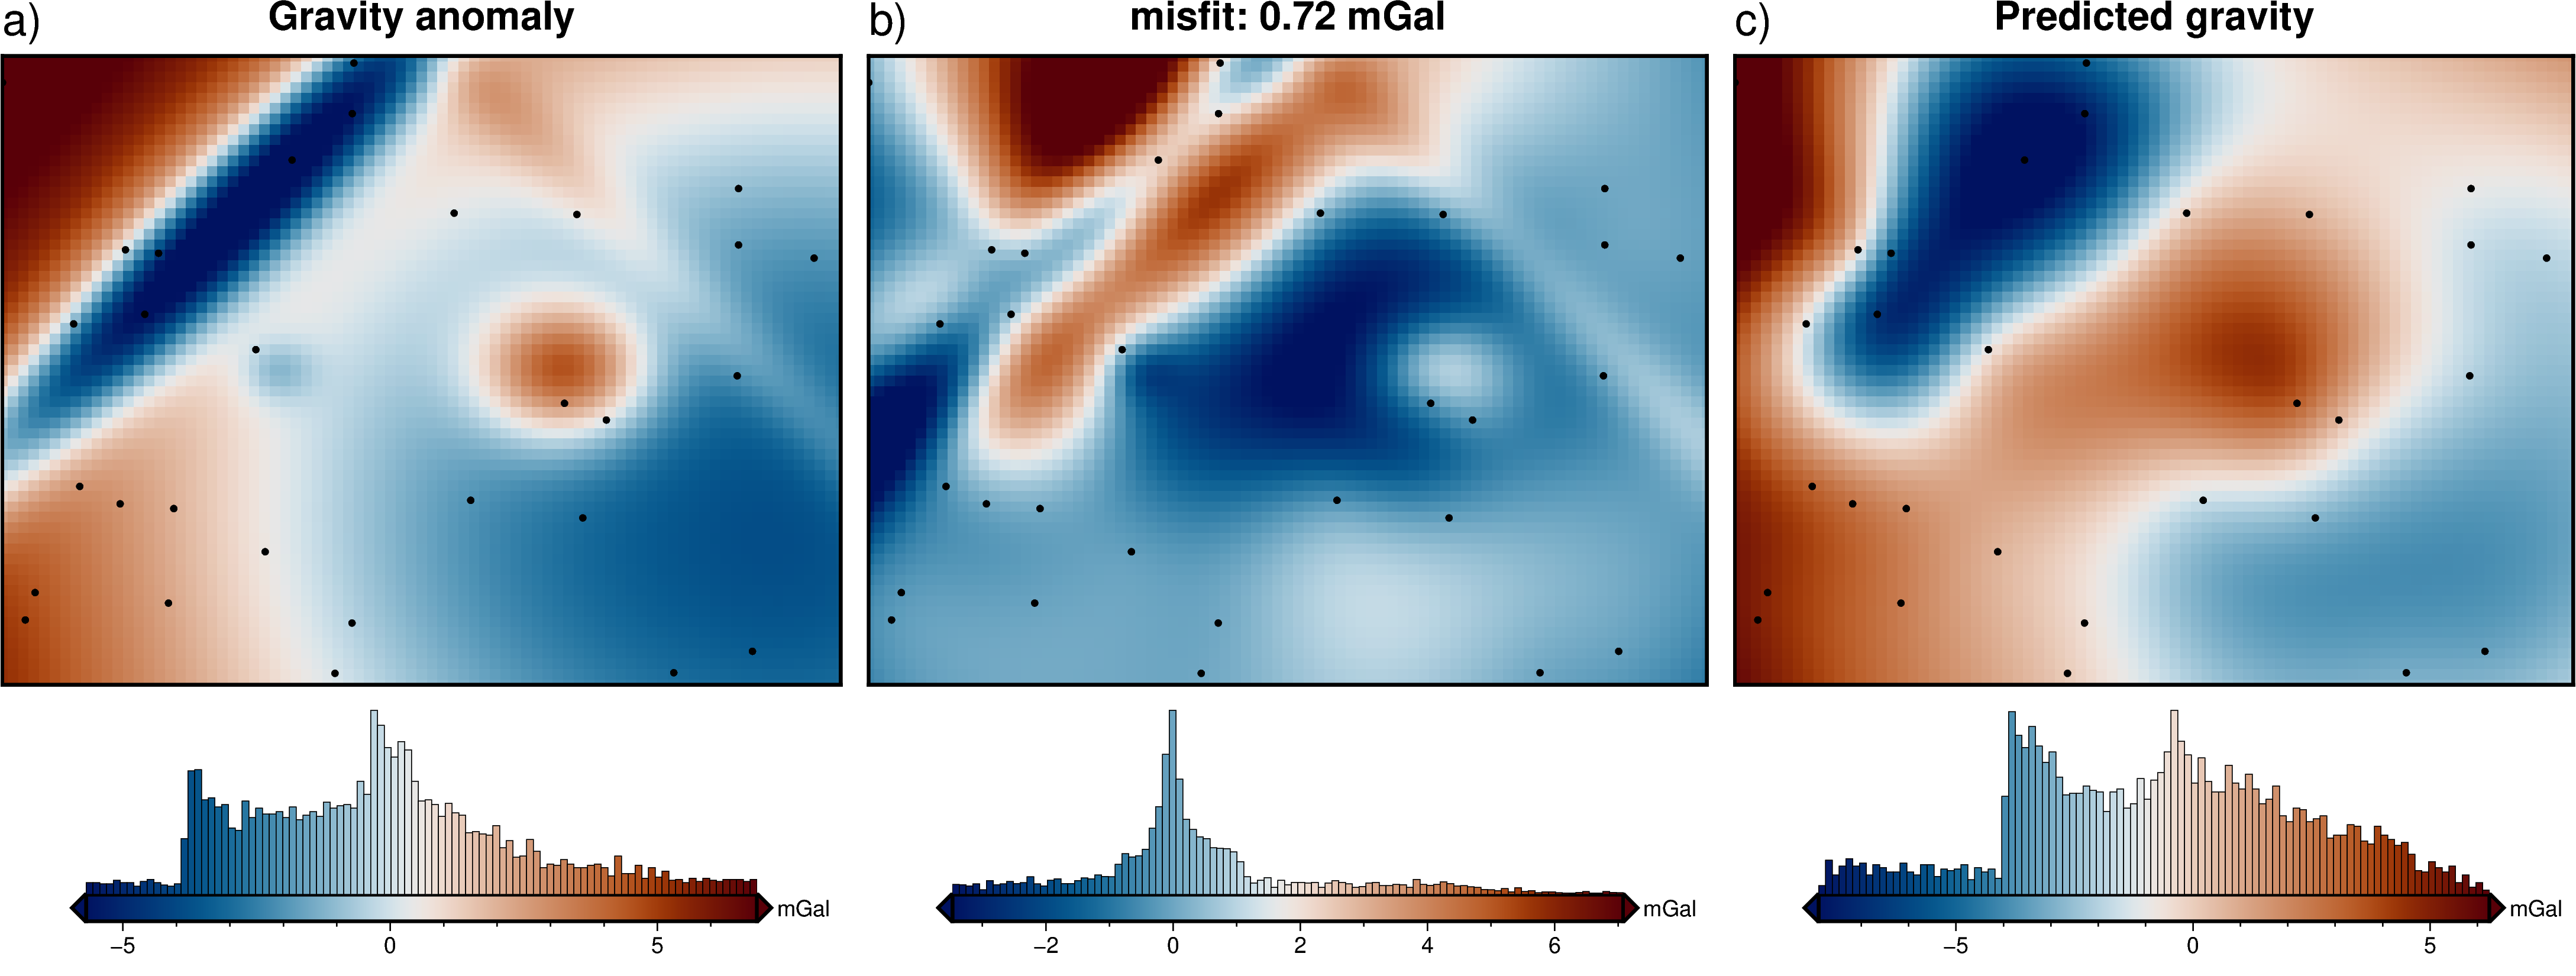

In [16]:
plotting.misfit_plotting(
    full_res_grav,
    plot_type="pygmt",
    input_forward_column="layer1_forward",
    input_grav_column="Gobs_shift",
    constraints=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="c0.1c",
)

gmtset [WARNING]: Representation of font type not recognized. Using default.
gmtset [WARNING]: Representation of font type not recognized. Using default.
gmtset [WARNING]: Representation of font type not recognized. Using default.


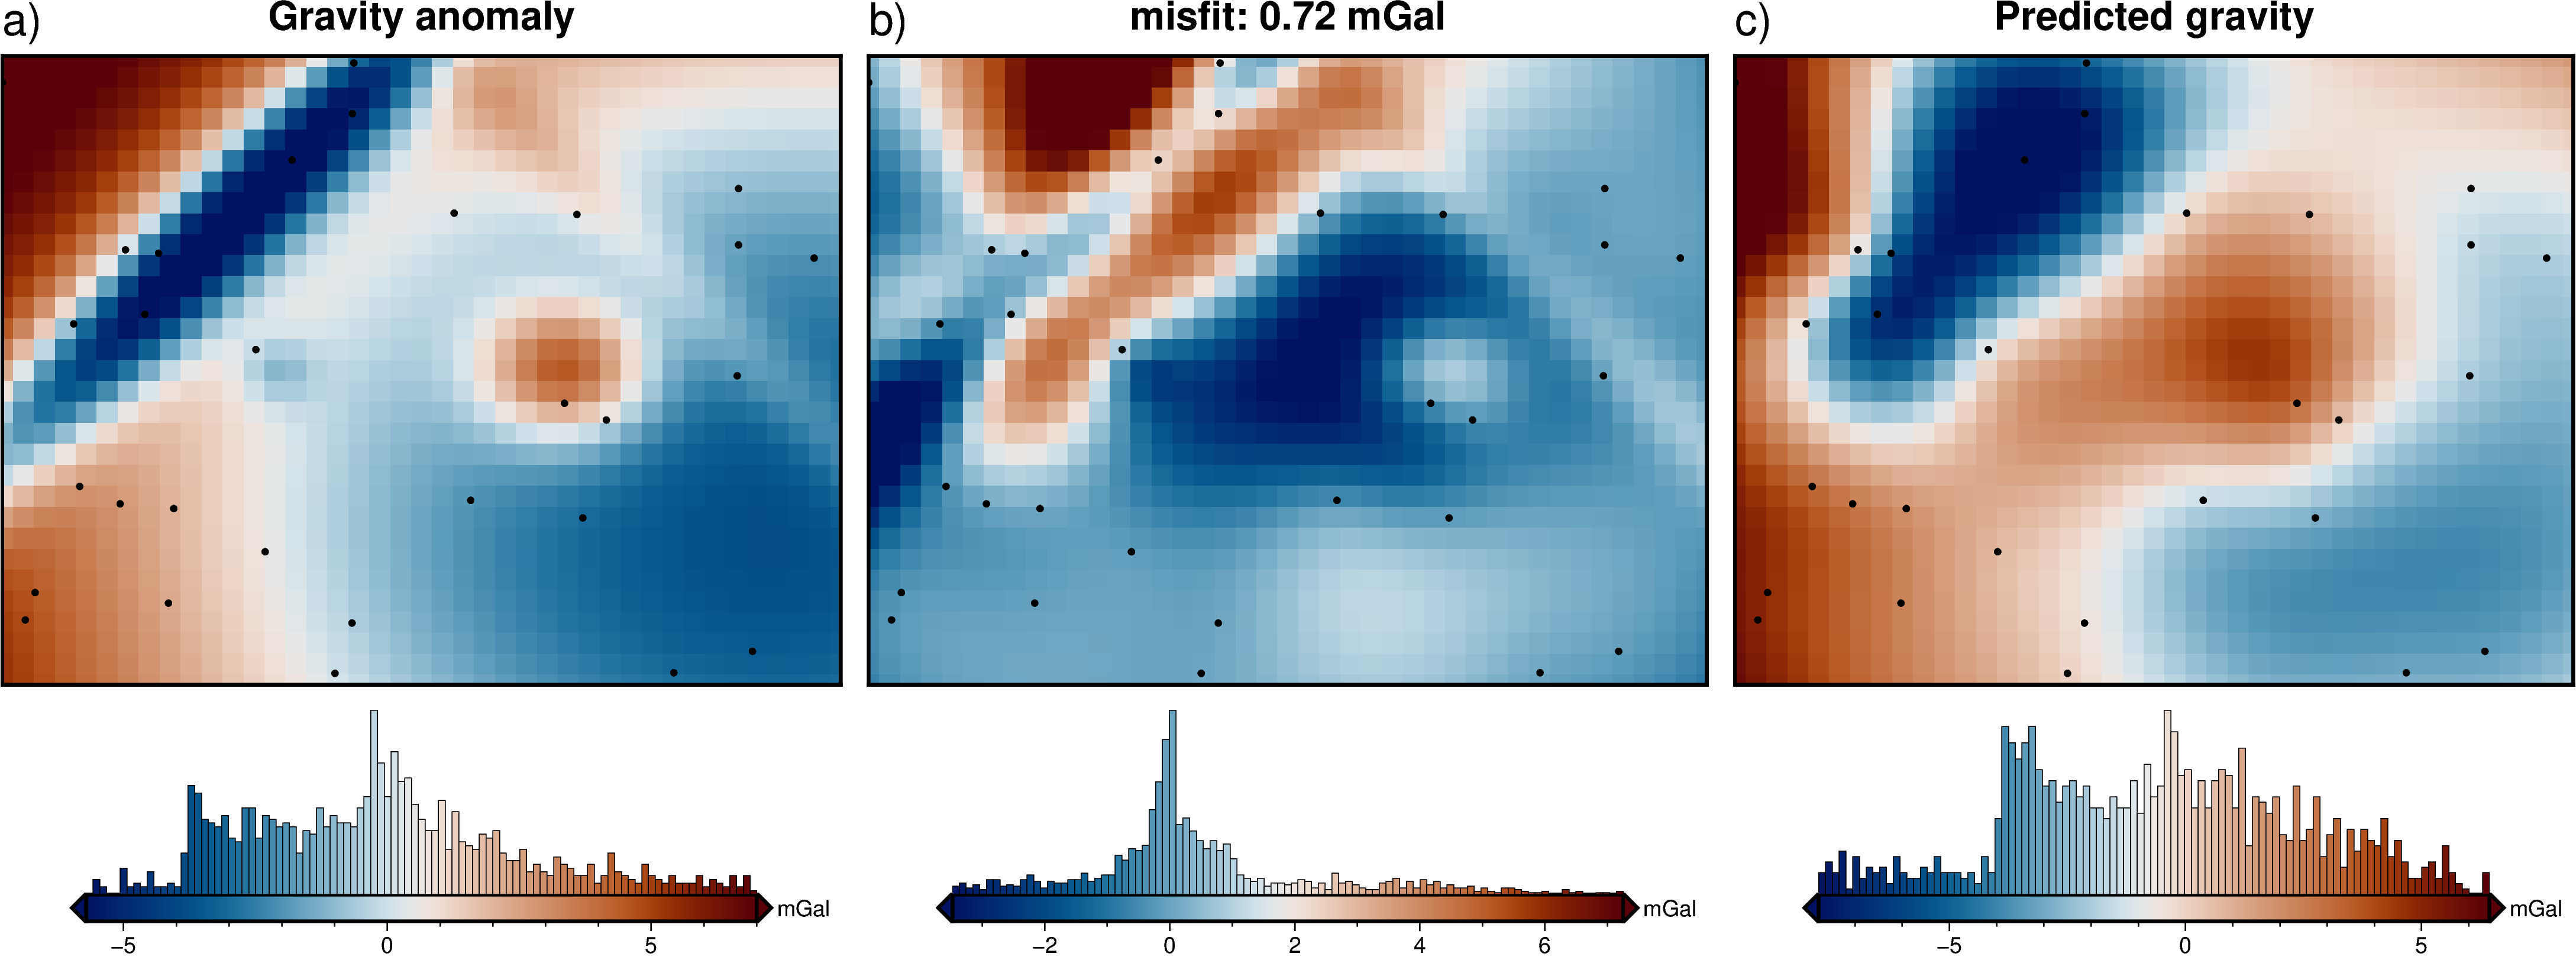

In [17]:
plotting.misfit_plotting(
    sampled_grav,
    plot_type="pygmt",
    input_forward_column="layer1_forward",
    input_grav_column="Gobs_shift",
    constraints=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="c0.1c",
)

gmtset [WARNING]: Representation of font type not recognized. Using default.
gmtset [WARNING]: Representation of font type not recognized. Using default.
gmtset [WARNING]: Representation of font type not recognized. Using default.


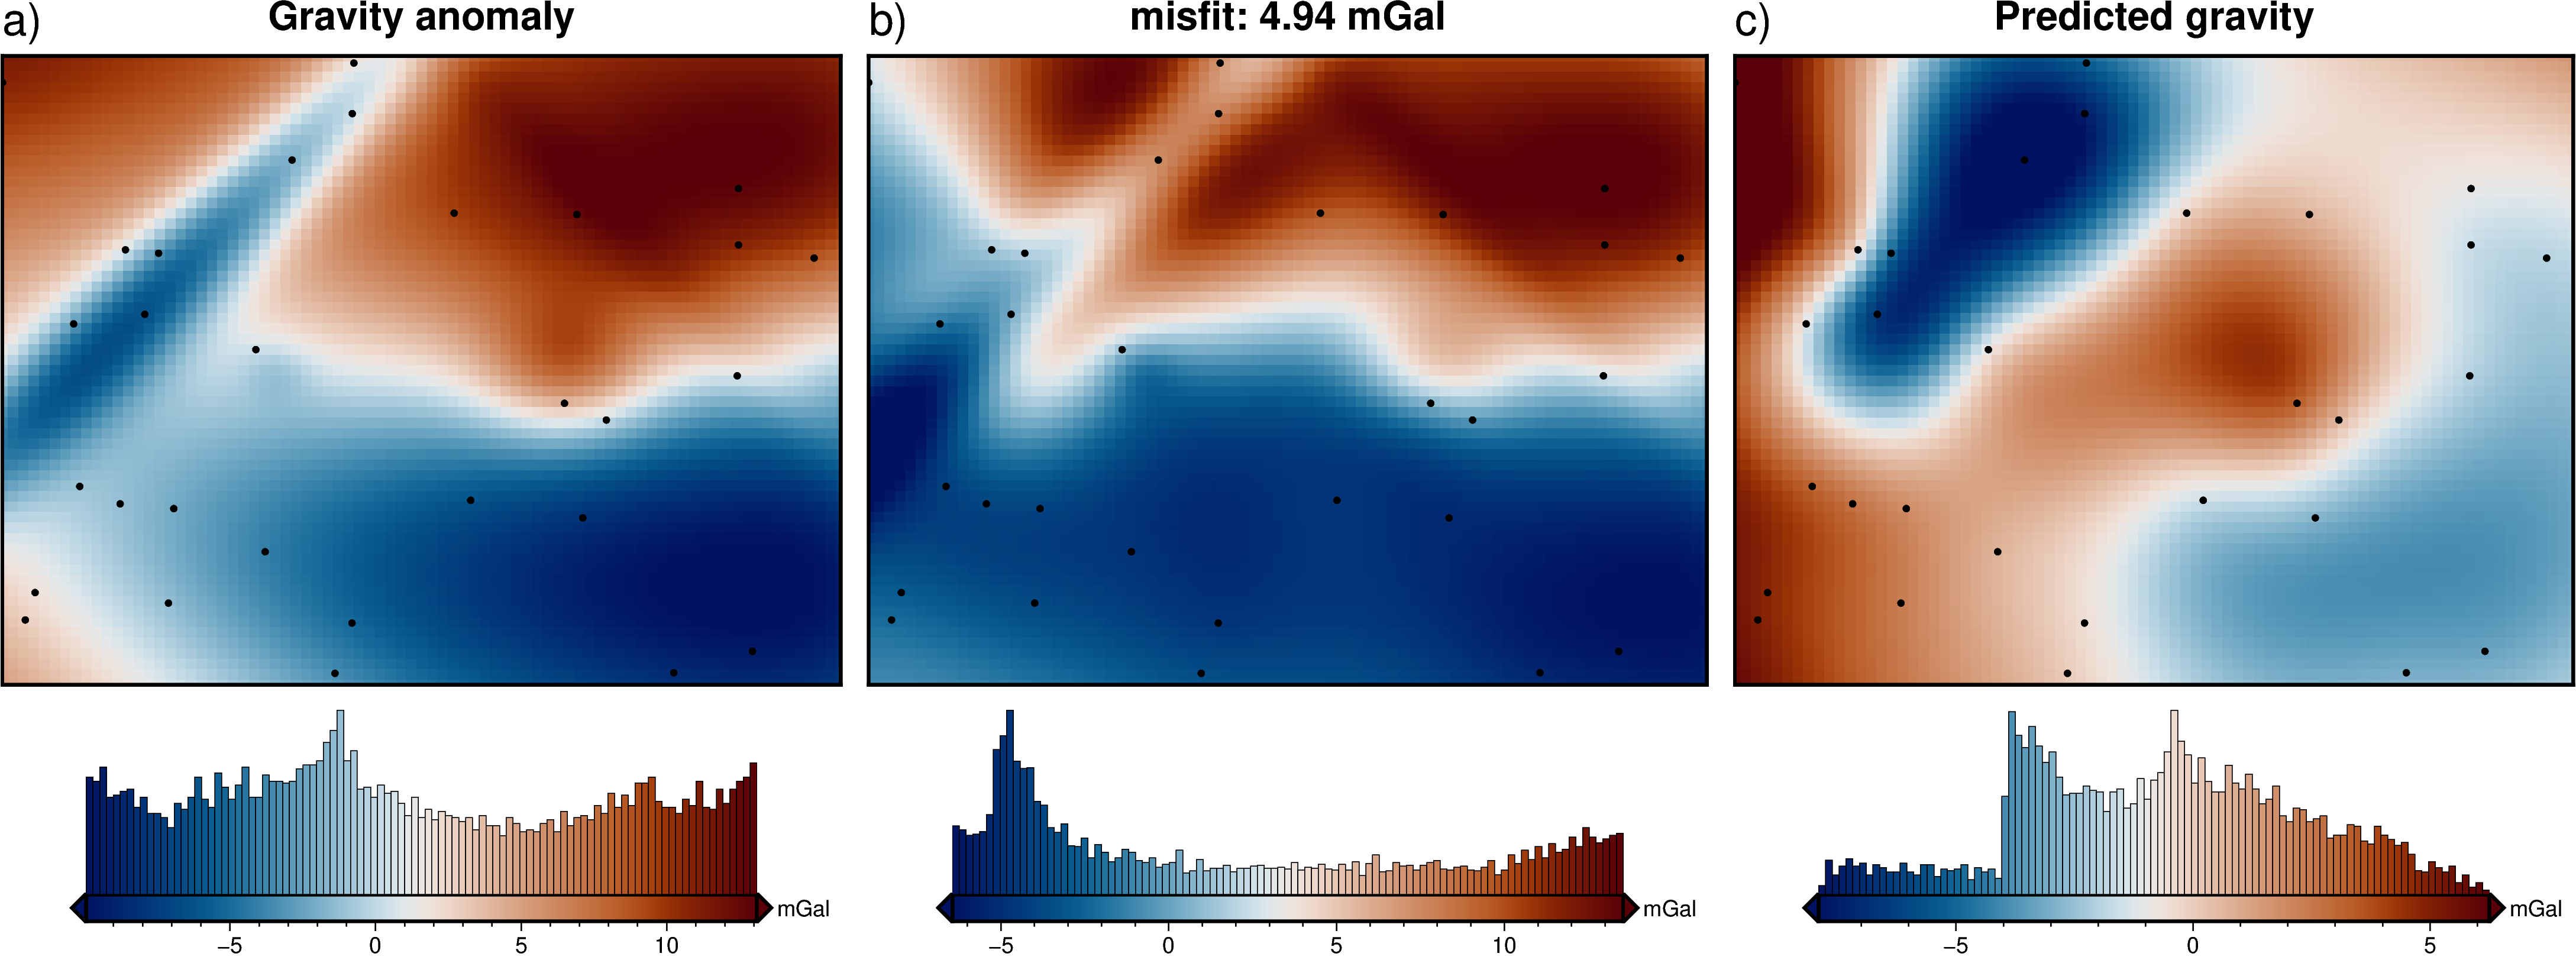

In [18]:
plotting.misfit_plotting(
    full_res_grav_with_reg,
    plot_type="pygmt",
    input_forward_column="layer1_forward",
    input_grav_column="Gobs_shift",
    constraints=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="c0.1c",
)

# Constraints grid

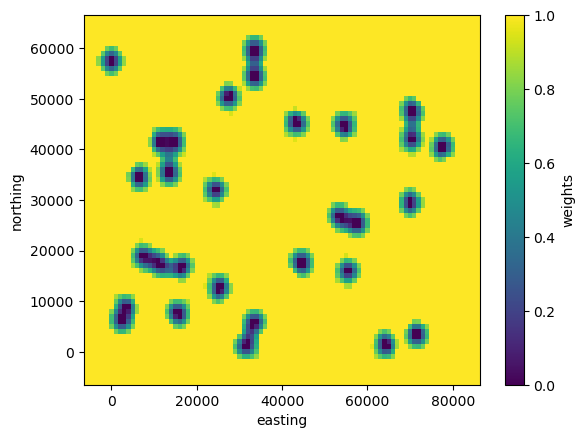

In [19]:
starting_prisms = copy.deepcopy(layer1_prisms)

weights, min_dist = inv_utils.constraints_grid(
    constraint_points,
    starting_prisms,
    inner_bound=1e3,
    outer_bound=3100,
    low=0,
    high=1,
    # region=inversion_region,
    interp_type="spline",
    # tension_factor = .35,
    # plot = True,
)
starting_prisms["weights"] = weights
starting_prisms["min_dist"] = min_dist
weights.plot()

### Save to Zarr

In [20]:
enc = {x: {"compressor": zarr.Blosc()} for x in starting_prisms}
starting_prisms.to_zarr(
    "../synthetic_data/synthetic_starting_prisms.zarr",
    encoding=enc,
    mode="w",
)

In [21]:
starting_prisms = xr.open_zarr("../synthetic_data/synthetic_starting_prisms.zarr")

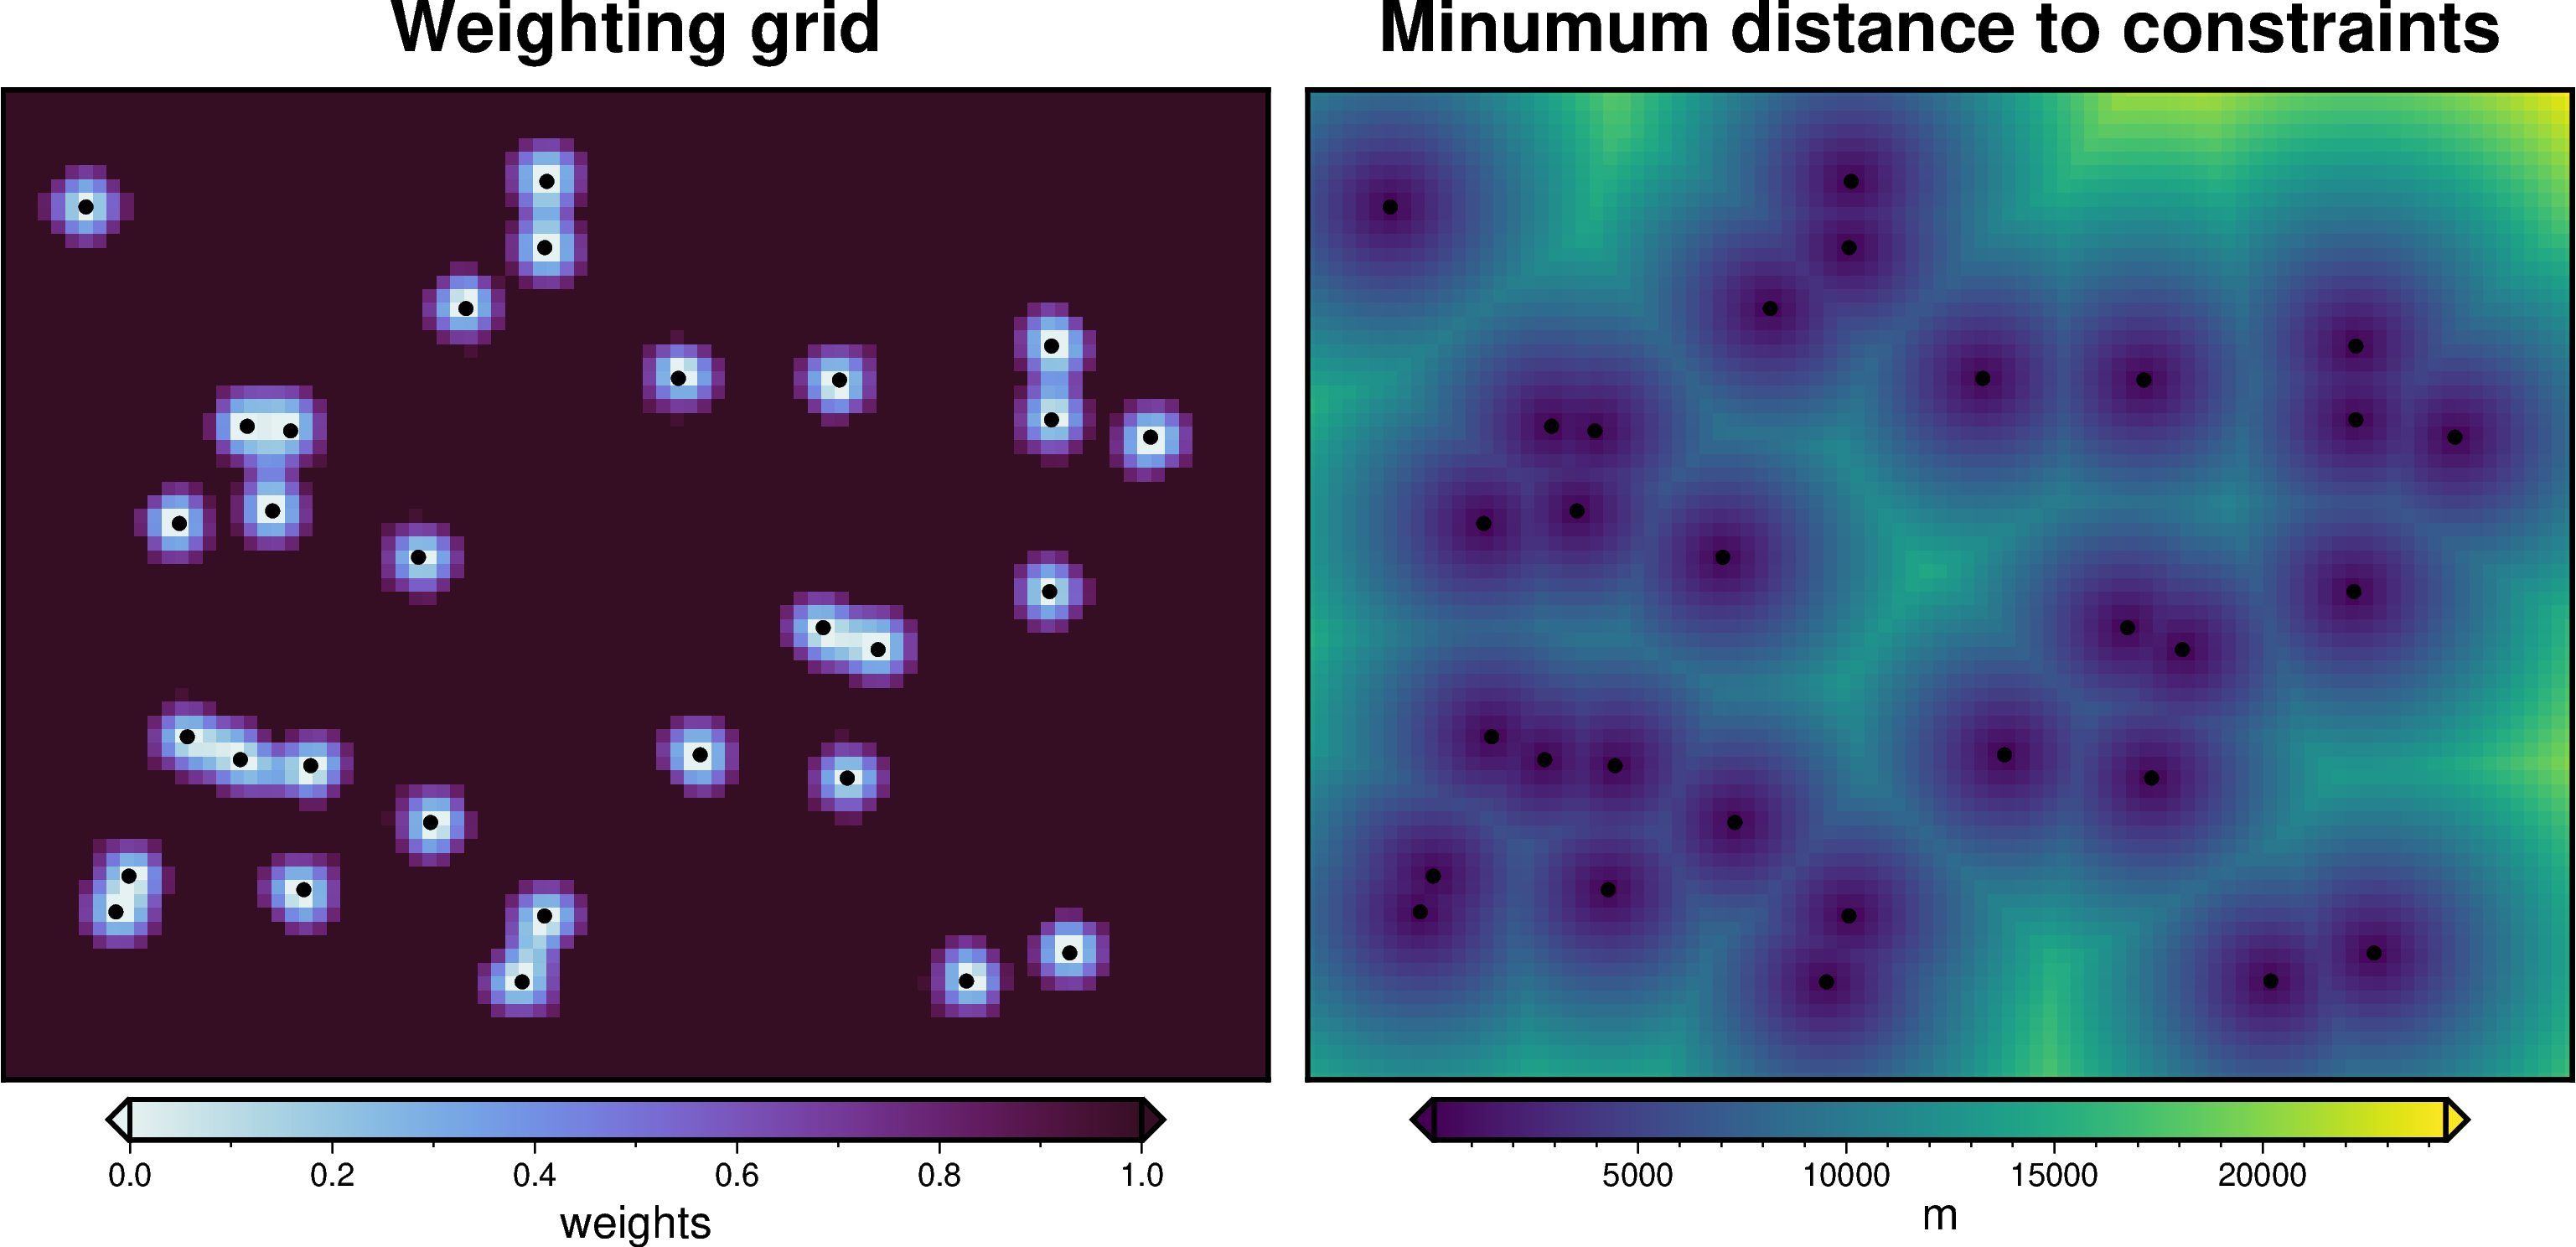

In [22]:
fig = maps.plot_grd(
    starting_prisms.weights,
    fig_height=10,
    title="Weighting grid",
    cbar_label="weights",
    cmap="dense",
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="c0.15c",
)
fig = maps.plot_grd(
    starting_prisms.min_dist,
    fig=fig,
    origin_shift="xshift",
    title="Minumum distance to constraints",
    cbar_label="m",
    cmap="viridis",
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="c0.15c",
)

fig.show()

# Inversion with no regional
## Set regional component to 0 for simple models

In [23]:
full_res_grav["reg"] = 0
full_res_grav["res"] = full_res_grav.misfit
print(full_res_grav.res.median())

sampled_grav["reg"] = 0
sampled_grav["res"] = sampled_grav.misfit
print(sampled_grav.res.median())
full_res_grav

0.0602658834489413
0.0524437439284746


northing  easting      Gobs  Surface2  forward_total  upward  \
0          0.0      0.0  4.895946 -1.585934       3.310012  1000.0   
1          0.0   1000.0  4.764286 -1.697236       3.067050  1000.0   
2          0.0   2000.0  4.616825 -1.806994       2.809832  1000.0   
3          0.0   3000.0  4.458949 -1.915200       2.543749  1000.0   
4          0.0   4000.0  4.294071 -2.021884       2.272188  1000.0   
...        ...      ...       ...       ...            ...     ...   
4936   60000.0  76000.0  0.829439  8.586936       9.416375  1000.0   
4937   60000.0  77000.0  0.825047  8.508668       9.333715  1000.0   
4938   60000.0  78000.0  0.822520  8.397605       9.220126  1000.0   
4939   60000.0  79000.0  0.821311  8.246703       9.068014  1000.0   
4940   60000.0  80000.0  0.820536  8.046806       8.867341  1000.0   

      layer1_forward  Gobs_shift    misfit  reg       res  
0           6.004718    5.322172 -0.682545    0 -0.682545  
1           5.751148    5.190513 -0.560635    0 -0.560635  
2           5.492230    5.043052 -0.449177    0 -0.449177  
3           5.235439    4.885176 -0.350264    0 -0.350264  
4           4.984941    4.720298 -0.264643    0 -0.264643  
...              ...         ...       ...  ...       ...  
4936        1.247832    1.255666  0.007833    0  0.007833  
4937        1.338739    1.251274 -0.087465    0 -0.087465  
4938        1.432526    1.248747 -0.183779    0 -0.183779  
4939        1.528039    1.247538 -0.280502    0 -0.280502  
4940        1.623114    1.246762 -0.376352    0 -0.376352  

[4941 rows x 11 columns]

In [ ]:
# # set kwargs for inversion
# kwargs = dict(
#     input_grav_column="Gobs_shift",
#     prism_layer=starting_prisms,
#     max_iterations=100,
#     l2_norm_tolerance=0.01,
#     delta_l2_norm_tolerance=1.01, # stop if l2-norm doesnt decrease by at least 1%
#     # apply_weights = True,
#     weights_after_solving = True,
#     deriv_type = "annulus",
#     solver_type = "scipy least squares",
#     solver_damping = 10**-2,   
# )

# results = inv.inversion_RMSE(
    
#     # input_grav=full_res_grav,
#     input_grav=sampled_grav,
    
#     inversion_region=inversion_region,
#     true_surface = layer1,
#     constraints=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
#     plot=True,
#     plot_type="xarray",
#     **kwargs,
# )

# (
#     rmse,
#     prism_results,
#     grav_results,
#     params,
#     elapsed_time,
#     constraints_rmse,
# ) = results

# _ = plotting.plot_inversion_results(
#         grav_results,
#         prism_results,
#         params,
#         grav_region=inversion_region,
#         plot_iter_results=True,
#         plot_topo_results=True,
#         plot_grav_results=True,
#         iters_to_plot=4,

#         # grav_spacing=grav_spacing,
#         grav_spacing=sampled_grav_spacing,

#         constraints=constraint_points,
#     )

# print(f"RMSE: {rmse}")
# print(f"constraints RMSE: {constraints_rmse}")

## Optimize the inversion

To determine optimal inversion parameters, we will run an optimization routine which minimizes the root median square error (RMSE) of the ending Surface 2 to the true Surface 2. 

The parameters we will test are:
* Solver damping

In [24]:

# set kwargs for inversion
kwargs = dict(
    input_grav=full_res_grav,
    input_grav_column="Gobs_shift",
    # prism_layer=starting_prisms,
    inversion_region=inversion_region,
    max_iterations=100,
    l2_norm_tolerance=0.01,
    delta_l2_norm_tolerance=1.01, # stop if l2-norm doesnt decrease by at least 1%
    # apply_weights = True,
    weights_after_solving = True,
    deriv_type = "annulus",
    solver_type = "scipy least squares",
)

# set name and storage for the optimization
study_name = "synthetic_simple_no_reg_inversion_damping_weights"
fname = f"../optimization_logs/{study_name}.log"

# remove if exists
# pathlib.Path(fname).unlink(missing_ok=True)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="JournalStorage is experimental")
    storage = JournalStorage(JournalFileStorage(fname))


In [ ]:
# set number of runs
n_trials = 50

# set objectives
objectives = [
    "RMSE"
    # "duration"
    # "constraints"
]

# set directions
directions = [
    "minimize"
    # "minimize"
    # "minimize"
]

# define search space if using GridSampler
search_space = {
    "damping": np.arange(-6, 1, step=1, dtype="float"),
    # "weights_inner": np.arange(1e3, 1900, step=100),
    "weights_outer": np.arange(2e3, 20e3, step=2e3, dtype="float"),
}
# create study
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="BoTorch")
    study = optuna.create_study(
        study_name=study_name,
        storage=storage,
        directions=directions,
        # sampler=optuna.samplers.TPESampler(n_startup_trials=int(n_trials/3)),
        # sampler=optuna.integration.BoTorchSampler(n_startup_trials=int(n_trials/3)),
        sampler=optuna.samplers.GridSampler(search_space),
        load_if_exists=True,
        )

# define the objective function
objective_func = optimization.optimal_inversion_damping_and_weights(
    layer1,
    damping_limits = [-6, 1], # damping = 10^damping_limit
    weights_inner_limits = [1e3],#[1e3, 1900],
    weights_outer_limits = [2e3, 20e3],
    weights_step = 100,
    starting_prisms = starting_prisms,
    objectives = objectives,
    constraints = constraint_points,
    **kwargs)

# objective_func = optimization.optimal_inversion_damping(
#     layer1,
#     damping_limits = [-10, 1], # damping = 10^damping_limit
#     objectives = objectives,
#     constraints = constraint_points,
#     **kwargs)

# run the optimization
# with inv_utils.HiddenPrints():
#     study, study_df = optimization.optuna_parallel(
#         study_name=study_name,
#         study_storage=storage,
#         objective = objective_func,
#         n_trials=n_trials,
#         maximize_cpus=True,
#         parallel=True,
#     )

In [ ]:
# load and plot past study
study = optuna.load_study(
    study_name=study_name,
    storage=storage,
)
print(study.best_trial)
# plotting.plot_optuna_inversion_figures(
#     study,
#     target_names=objectives,
#     # include_duration=True,
# )

In [ ]:
weights, _ = inv_utils.constraints_grid(
    constraint_points,  
    starting_prisms.drop("weights"),
    inner_bound=1e3, #study.best_params['weights_inner'],
    outer_bound=study.best_params['weights_outer'],
    low=0,
    high=1,
    # region=inversion_region,
    interp_type="spline",
)
        
starting_prisms["weights"] = weights
        
plotting.plot_best_inversion(
    true_surface=layer1,
    prism_layer = starting_prisms,
    best_params=study.best_params,
    grav_spacing=grav_spacing,
    constraint_points=constraint_points,
    plot_type="pygmt",
    **kwargs
)

### Repeat with noise

The above inversion was able to fully recover Layer 2. This is expected, since there was no noise in the data, and we used a very simple 2 layer model to create the observed gravity. Next we add 2% gaussian noise to $G_{misfit}$ to see how the inversion performs.

In [ ]:
# contaminate with noise
full_res_grav_noise = full_res_grav.copy()
full_res_grav_noise["Gobs"] = synthetic.contaminate(
    full_res_grav_noise.Gobs,
    stddev=0.02,
    percent=True,
    seed=0,
)
# DC shift and calculate misfit
full_res_grav_noise = inv.misfit(
    input_grav=full_res_grav_noise,
    input_forward_column="layer1_forward",
    input_grav_column="Gobs",
    constraints=constraint_points,
)
# set regional to 0
full_res_grav_noise["reg"] = 0
full_res_grav_noise["res"] = full_res_grav_noise.misfit
print(full_res_grav_noise.res.median())

full_res_grav_noise

In [ ]:
plotting.misfit_plotting(
    full_res_grav_noise,
    # grav_spacing=grav_spacing,
    plot_type="pygmt",
    input_forward_column="layer1_forward",
    input_grav_column="Gobs_shift",
    constraints=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="c0.1c",
)

In [ ]:
# set kwargs for inversion
kwargs = dict(
    input_grav=full_res_grav_noise,
    input_grav_column="Gobs_shift",
    # prism_layer=starting_prisms,
    inversion_region=inversion_region,
    max_iterations=100,
    l2_norm_tolerance=0.01,
    delta_l2_norm_tolerance=1.01, # stop if l2-norm doesn't decrease by at least 1%
    # apply_weights = True,
    weights_after_solving = True,
    deriv_type = "annulus",
    solver_type = "scipy least squares",
)

# set name and storage for the optimization
study_name = "synthetic_simple_no_reg_noise_inversion_damping_weights"
fname = f"../optimization_logs/{study_name}.log"

# remove if exists
pathlib.Path(fname).unlink(missing_ok=True)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="JournalStorage is experimental")
    storage = JournalStorage(JournalFileStorage(fname))

In [ ]:
# set number of runs
n_trials = 50

# set objectives
objectives = [
    "RMSE"
    # "duration"
    # "constraints"
]

# set directions
directions = [
    "minimize"
    # "minimize"
    # "minimize"
]

# define search space if using GridSampler
search_space = {
    "damping": np.arange(-6, 1, step=1, dtype="float"),
    # "weights_inner": np.arange(1e3, 1900, step=100),
    "weights_outer": np.arange(2e3, 20e3, step=2e3, dtype="float"),
}
# create study
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="BoTorch")
    study = optuna.create_study(
        study_name=study_name,
        storage=storage,
        directions=directions,
        # sampler=optuna.samplers.TPESampler(n_startup_trials=int(n_trials/3)),
        # sampler=optuna.integration.BoTorchSampler(n_startup_trials=int(n_trials/3)),
        sampler=optuna.samplers.GridSampler(search_space),
        load_if_exists=True,
        )

# define the objective function
objective_func = optimization.optimal_inversion_damping_and_weights(
    layer1,
    damping_limits = [-6, 1], # damping = 10^damping_limit
    weights_inner_limits = [1e3],#[1e3, 1900],
    weights_outer_limits = [2e3, 15e3],
    weights_step = 100,
    starting_prisms = starting_prisms,
    objectives = objectives,
    constraints = constraint_points,
    **kwargs)

# objective_func = optimization.optimal_inversion_damping(
#     layer1,
#     damping_limits = [-10, 1], # damping = 10^damping_limit
#     objectives = objectives,
#     constraints = constraint_points,
#     **kwargs)

# run the optimization
with inv_utils.HiddenPrints():
    study, study_df = optimization.optuna_parallel(
        study_name=study_name,
        study_storage=storage,
        objective = objective_func,
        n_trials=n_trials,
        maximize_cpus=True,
        parallel=True,
    )

In [ ]:
# load and plot past study
study = optuna.load_study(
    study_name=study_name,
    storage=storage,
)
print(study.best_trial)
plotting.plot_optuna_inversion_figures(
    study,
    target_names=objectives,
    # include_duration=True,
)

In [ ]:
weights, _ = inv_utils.constraints_grid(
    constraint_points,  
    starting_prisms.drop("weights"),
    inner_bound=1e3, #study.best_params['weights_inner'],
    outer_bound=study.best_params['weights_outer'],
    low=0,
    high=1,
    # region=inversion_region,
    interp_type="spline",
)
        
starting_prisms["weights"] = weights
        
plotting.plot_best_inversion(
    true_surface=layer1,
    prism_layer = starting_prisms,
    best_params=study.best_params,
    grav_spacing=grav_spacing,
    constraint_points=constraint_points,
    plot_type="pygmt",
    **kwargs
)

## Repeat with sampled data

In [ ]:
# contaminate with noise
sampled_grav_noise = sampled_grav.copy()
sampled_grav_noise["Gobs"] = synthetic.contaminate(
    sampled_grav_noise.Gobs,
    stddev=0.02,
    percent=True,
    seed=0,
)
# DC shift and calculate misfit
sampled_grav_noise = inv.misfit(
    input_grav=sampled_grav_noise,
    input_forward_column="layer1_forward",
    input_grav_column="Gobs",
    constraints=constraint_points,
)
# set regional to 0
sampled_grav_noise["reg"] = 0
sampled_grav_noise["res"] = sampled_grav_noise.misfit
print(sampled_grav_noise.res.median())

sampled_grav_noise

In [ ]:
plotting.misfit_plotting(
    sampled_grav_noise,
    # grav_spacing=sampled_grav_spacing,
    plot_type="pygmt",
    input_forward_column="layer1_forward",
    input_grav_column="Gobs_shift",
    constraints=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="c0.1c",
)

In [ ]:
# set kwargs for inversion
kwargs = dict(
    input_grav=sampled_grav_noise,
    input_grav_column="Gobs_shift",
    # prism_layer=starting_prisms,
    inversion_region=inversion_region,
    max_iterations=100,
    l2_norm_tolerance=0.01,
    delta_l2_norm_tolerance= 1.005,#1.01, # stop if l2-norm doesnt decrease by at least 1%
    # apply_weights = True,
    weights_after_solving = True,
    deriv_type = "annulus",
    solver_type = "scipy least squares",
)

# set name and storage for the optimization
study_name = "synthetic_simple_sampled_no_reg_noise_inversion_damping_weights_lowerdelta"
fname = f"../optimization_logs/{study_name}.log"

# remove if exists
# pathlib.Path(fname).unlink(missing_ok=True)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="JournalStorage is experimental")
    storage = JournalStorage(JournalFileStorage(fname))

In [ ]:
# set number of runs
n_trials = 50

# set objectives
objectives = [
    "RMSE"
    # "duration"
    # "constraints"
]

# set directions
directions = [
    "minimize"
    # "minimize"
    # "minimize"
]

# define search space if using GridSampler
search_space = {
    "damping": np.arange(-6, 1, step=1, dtype="float"),
    # "weights_inner": np.arange(1e3, 1900, step=100),
    "weights_outer": np.arange(2e3, 20e3, step=2e3, dtype="float"),
}
# create study
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="BoTorch")
    study = optuna.create_study(
        study_name=study_name,
        storage=storage,
        directions=directions,
        # sampler=optuna.samplers.TPESampler(n_startup_trials=int(n_trials/3)),
        # sampler=optuna.integration.BoTorchSampler(n_startup_trials=int(n_trials/3)),
        sampler=optuna.samplers.GridSampler(search_space),
        load_if_exists=True,
        )

# define the objective function
objective_func = optimization.optimal_inversion_damping_and_weights(
    layer1,
    damping_limits = [-6, 1], # damping = 10^damping_limit
    weights_inner_limits = [1e3],#[1e3, 1900],
    weights_outer_limits = [2e3, 15e3],
    weights_step = 100,
    starting_prisms = starting_prisms,
    objectives = objectives,
    constraints = constraint_points,
    **kwargs)

# objective_func = optimization.optimal_inversion_damping(
#     layer1,
#     damping_limits = [-10, 1], # damping = 10^damping_limit
#     objectives = objectives,
#     constraints = constraint_points,
#     **kwargs)

# run the optimization
with inv_utils.HiddenPrints():
    study, study_df = optimization.optuna_parallel(
        study_name=study_name,
        study_storage=storage,
        objective = objective_func,
        n_trials=n_trials,
        maximize_cpus=True,
        parallel=True,
    )

In [ ]:
# load and plot past study
study = optuna.load_study(
    study_name=study_name,
    storage=storage,
)
print(study.best_trial)
plotting.plot_optuna_inversion_figures(
    study,
    target_names=objectives,
    # include_duration=True,
)

In [ ]:
df = study.trials_dataframe().sort_values(by="value").iloc[1]
params = {'damping': df.params_damping.item(), 'weights_outer':  df.params_weights_outer}

# params = study.best_params

weights, _ = inv_utils.constraints_grid(
    constraint_points,  
    starting_prisms.drop("weights"),
    inner_bound=1e3,
    outer_bound=params['weights_outer'],
    low=0,
    high=1,
    # region=inversion_region,
    interp_type="spline",
)
        
starting_prisms["weights"] = weights
        
plotting.plot_best_inversion(
    true_surface=layer1,
    prism_layer = starting_prisms,
    best_params=params,
    grav_spacing=sampled_grav_spacing,
    constraint_points=constraint_points,
    plot_type="pygmt",
    **kwargs
)

# Regional - Residual seperation

The `corrected observed gravity` is the combination of the signal from the density contrasts of `Surface 2` and `Surface 3`. Both of these signals contain long-wavelength components, since both surface have long-wavelength topographic features. The `Surface 2` signal also contains short-wavelength components. Deeper in the crust, further away from the gravity observation points, these short-wavelength components decrease in amplitude. This means the majority the short-wavelength signal in the `corrected observed gravity` is resulting from the density contrast of `Surface 2`. This is the signal we want to isolate and input into the inversion. 

To do this, we need to seperate the gravity misfit into a `regional` component and a `residual` component. This `regional` field should theoretically contain every gravity signal other than the that resulting from the `Surface 2` surface. Additionaly, this `residual` component should theoretically represent the gravity anomaly due to the difference between the true `Surface 2` and the low-resolution `Surface 2`. 

If we fail to accurately remove the `regional` signal, the resulting `Surface 2` surface after the inversion will contain long-wavelength topography, resulting from the `regional` gravity field. 

Since we create the synthetic model, we precisely know the regional component (the forward gravity of `Surface 3`), and can thus tune our regional-residual seperation method to accurately remove the regional field. 

## Calculate regional component for other models 


########## filter ##########
number                                       19
value                                   1.48036
datetime_start       2023-04-15 11:58:40.541880
datetime_complete    2023-04-15 11:58:54.547361
duration                 0 days 00:00:14.005481
params_filter                             10000
state                                  COMPLETE
Name: 19, dtype: object


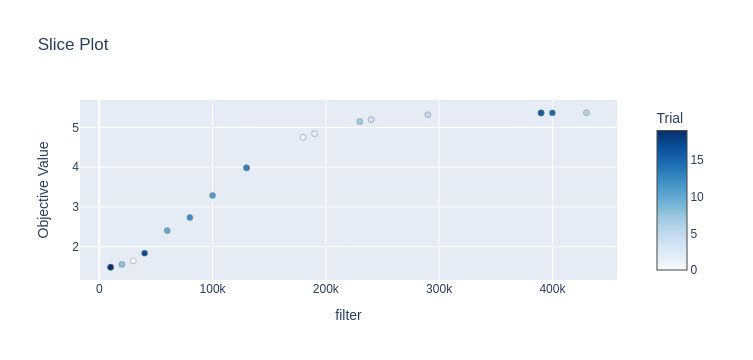


########## trend ##########
number                                        9
value                                  1.280509
datetime_start       2023-04-15 11:58:55.424790
datetime_complete    2023-04-15 11:59:07.971466
duration                 0 days 00:00:12.546676
params_trend                                  3
state                                  COMPLETE
Name: 9, dtype: object


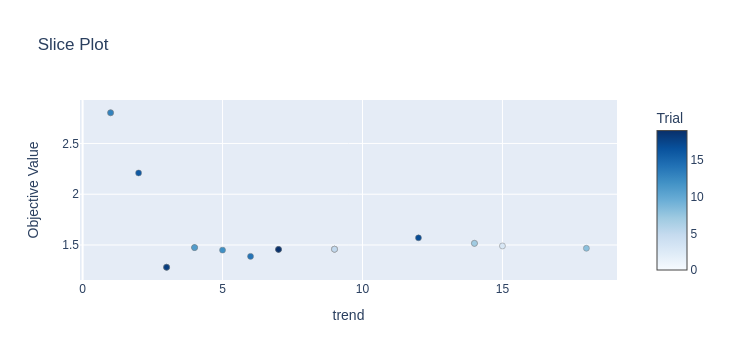


########## constraints ##########
number                                        11
value                                   1.421506
datetime_start        2023-04-15 11:59:19.039200
datetime_complete     2023-04-15 11:59:32.888106
duration                  0 days 00:00:13.848906
params_constraints                           0.0
state                                   COMPLETE
Name: 11, dtype: object


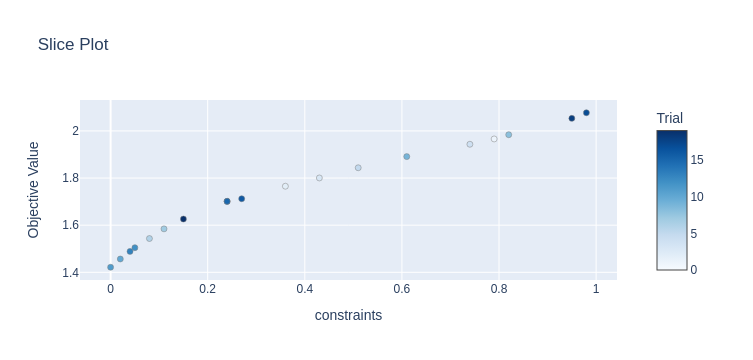


########## eq_sources ##########
number                                       16
value                                  1.258356
datetime_start       2023-04-15 11:59:43.071638
datetime_complete    2023-04-15 12:00:12.338343
duration                 0 days 00:00:29.266705
params_eq_sources                       2170000
state                                  COMPLETE
Name: 16, dtype: object


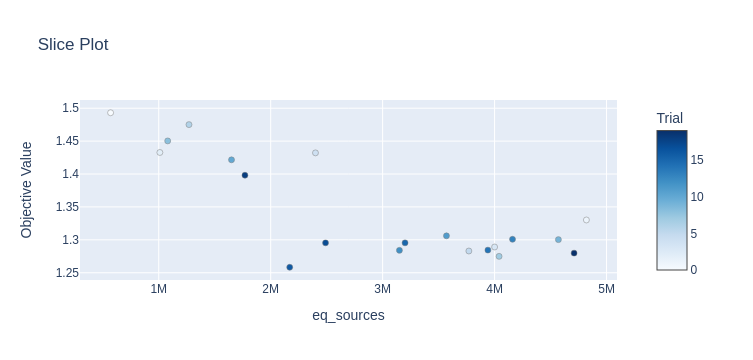

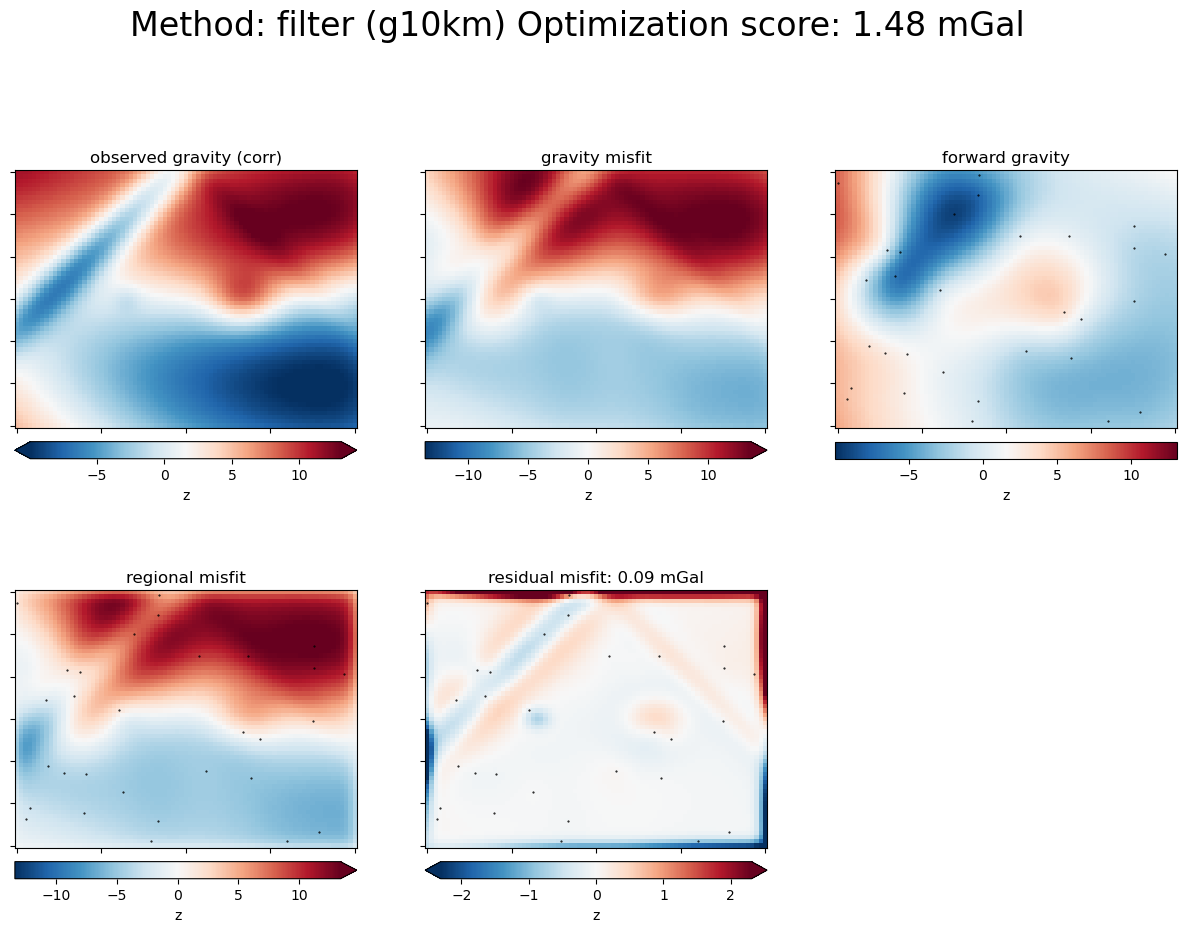

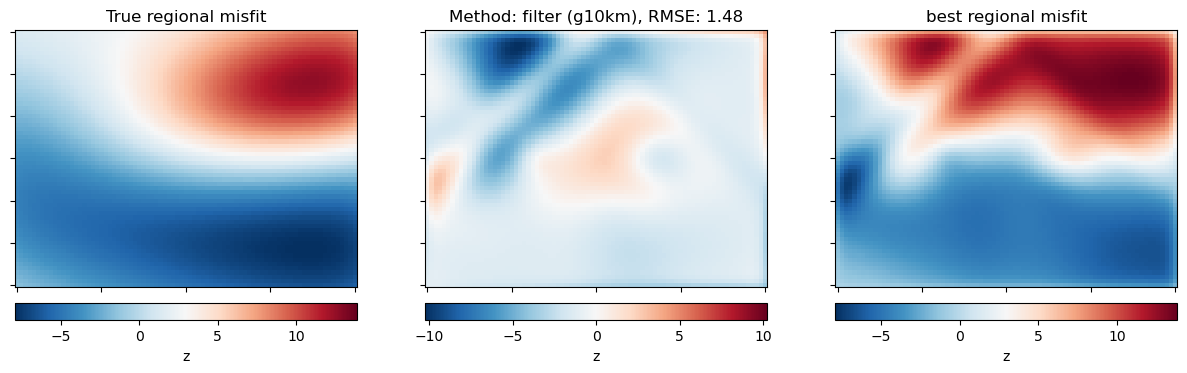

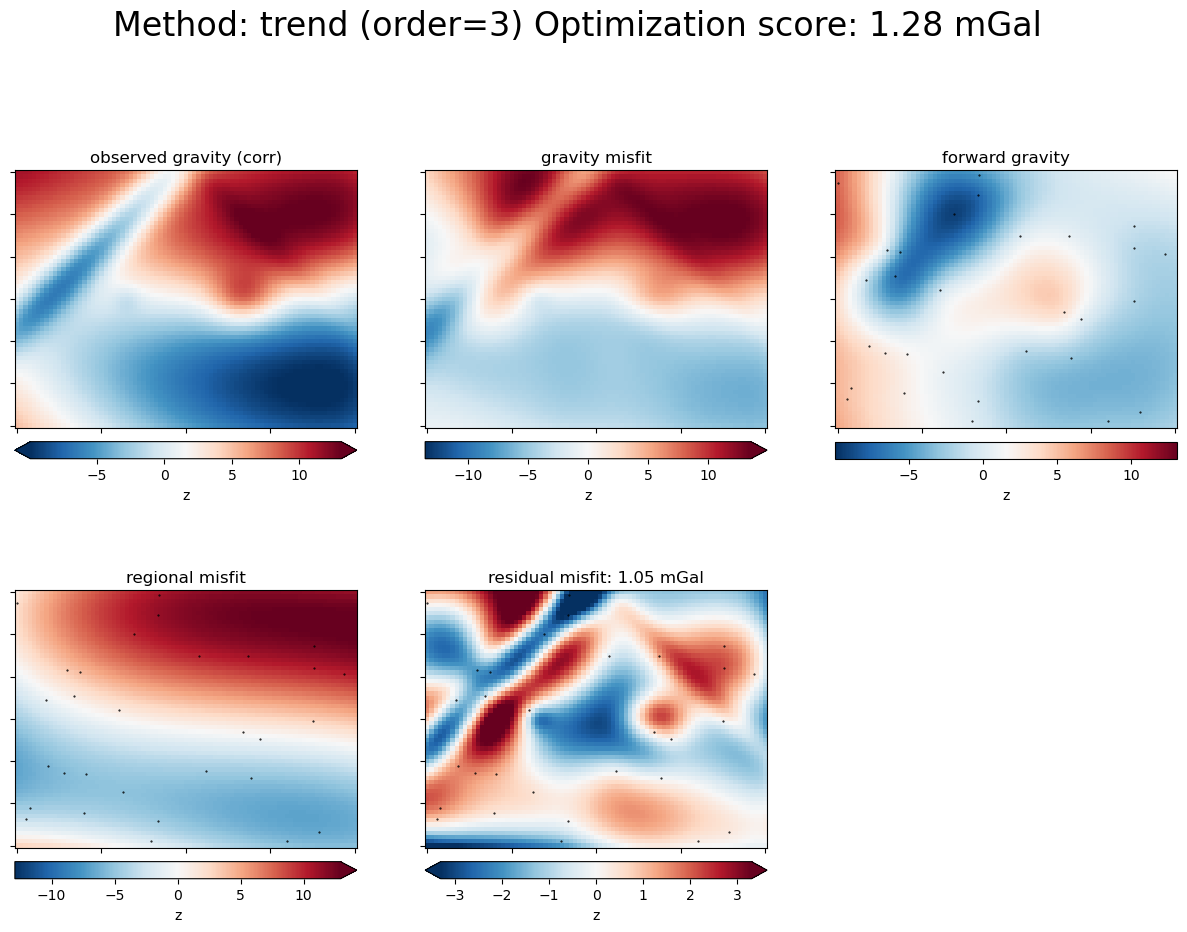

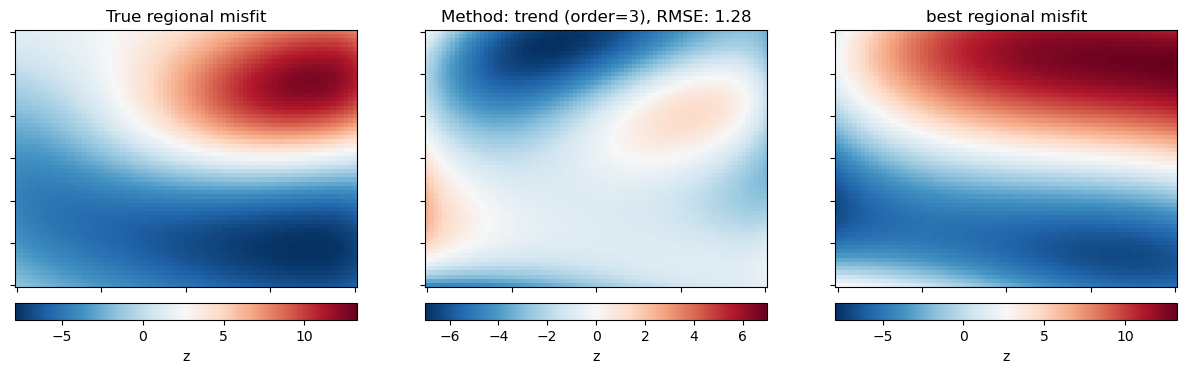

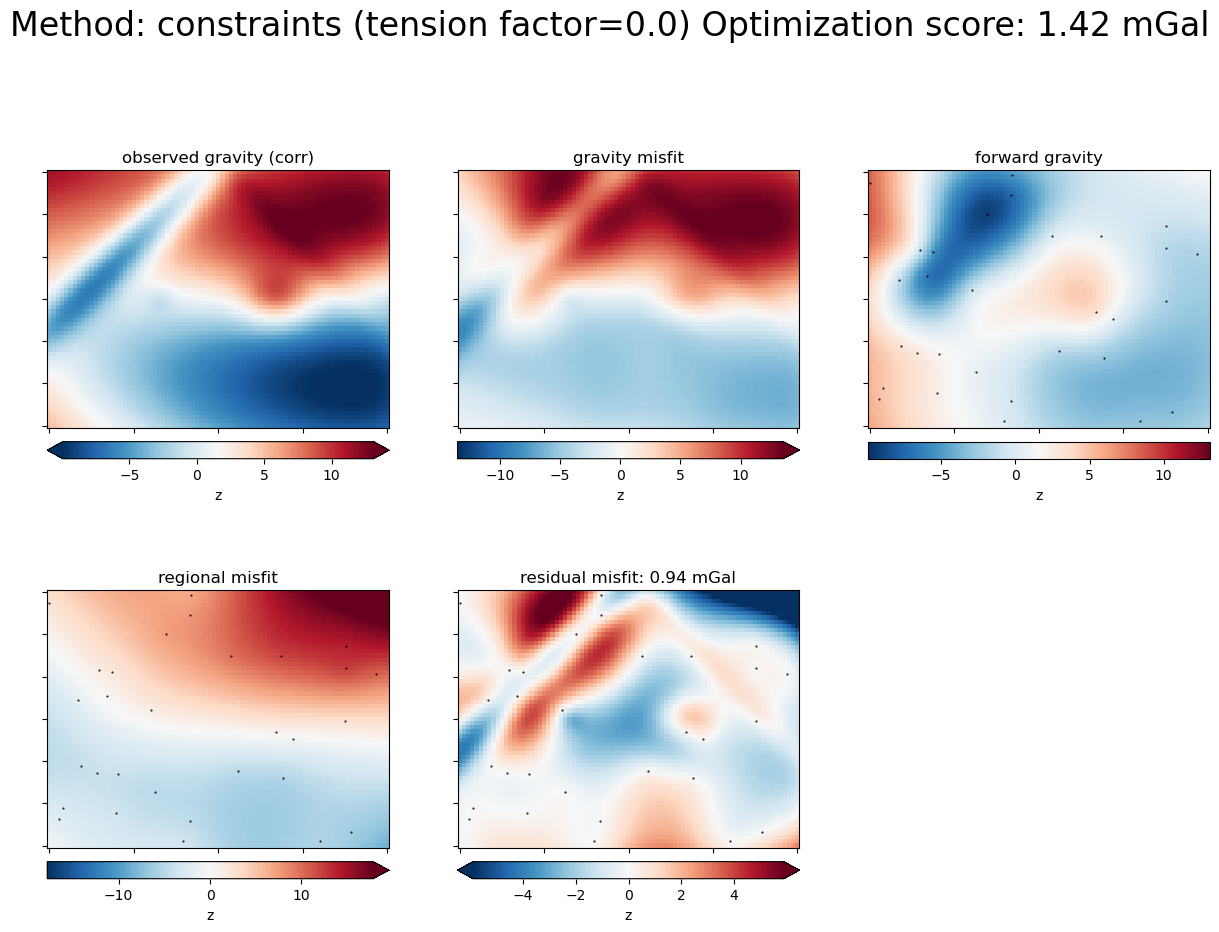

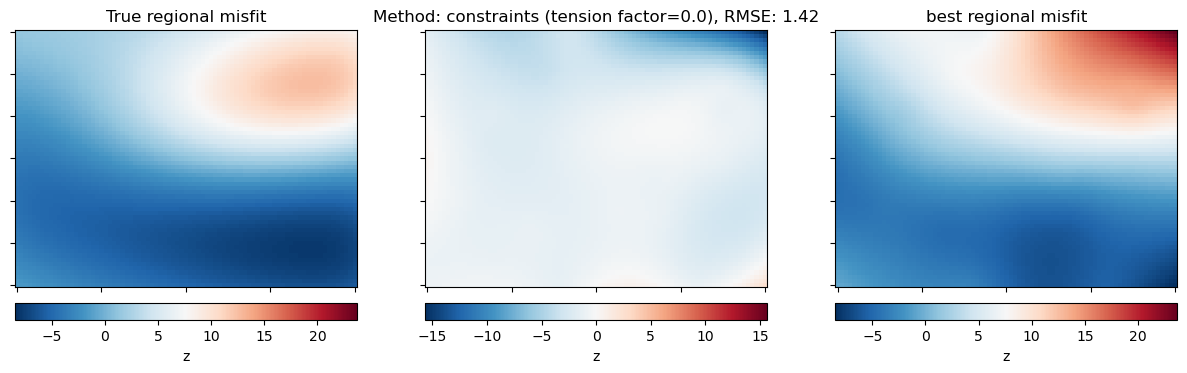

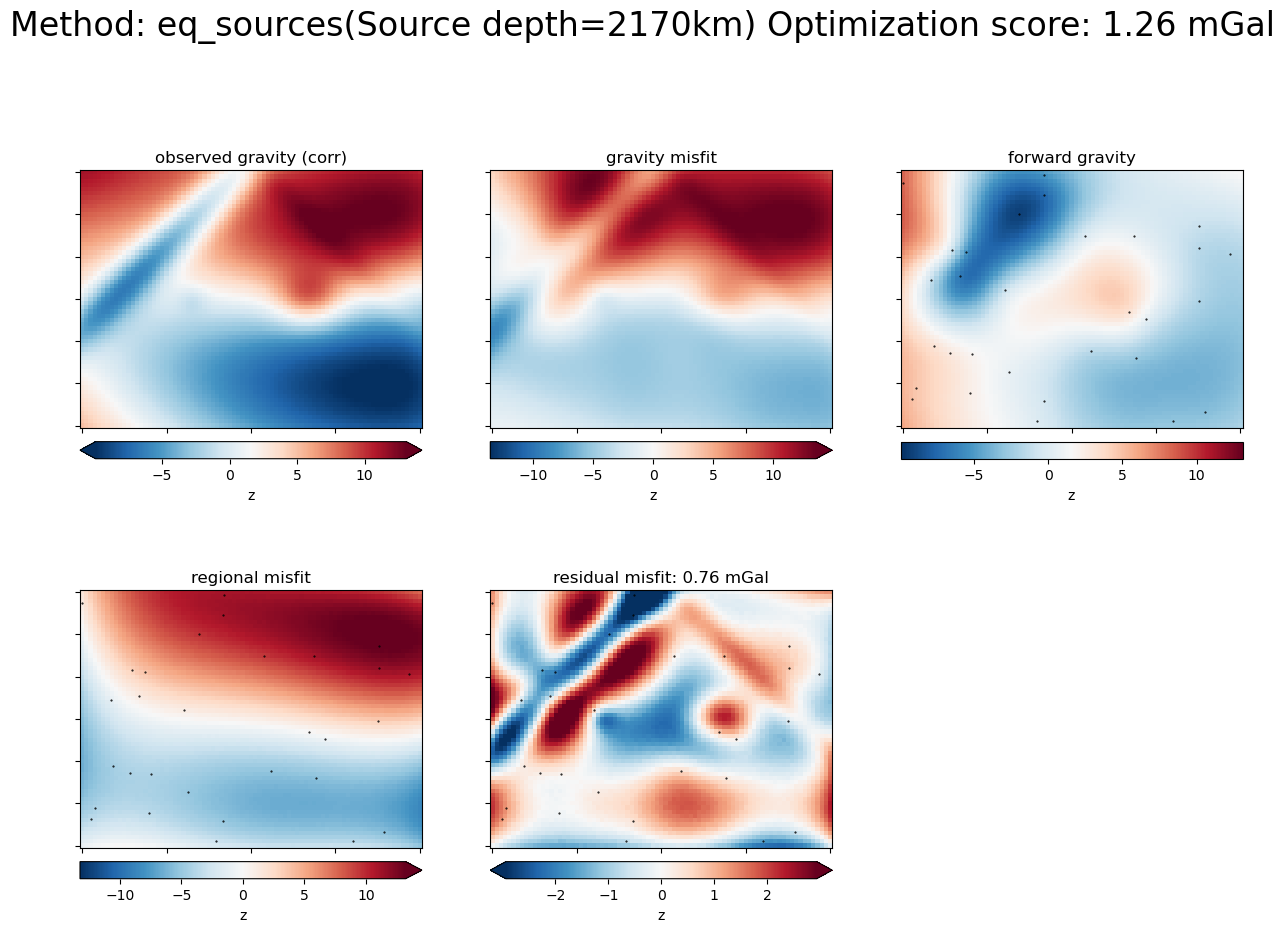

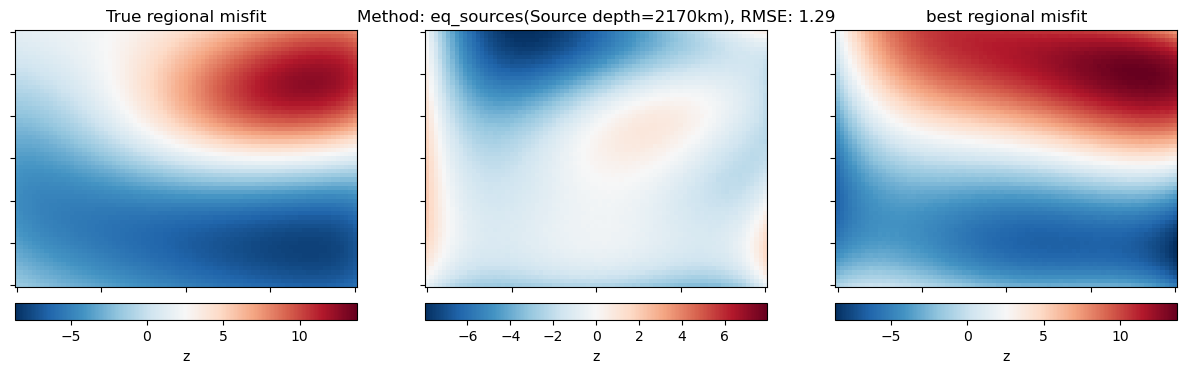

In [27]:
regional_kwargs = dict(
    input_grav=full_res_grav_with_reg,
    input_forward_column="layer1_forward",
    input_grav_column="Gobs_shift",
    grav_spacing=grav_spacing,
    inversion_region=inversion_region,
    true_regional=full_res_grav.set_index(["northing","easting"]).to_xarray().Surface2,
    constraints=constraint_points,
)

# set comparison method
# comparison_method='minimize_constraints'
comparison_method = "regional_comparison"

methods = ["filter", "trend", "constraints", "eq_sources"]

# for i in methods:
#     # set name and storage for the optimization
#     study_name = f"synthetic_simple_region_sep_indiv_{i}_{comparison_method}"
#     fname = f"../optimization_logs/{study_name}.log"
    
#     # remove if exists
#     # pathlib.Path(fname).unlink(missing_ok=True)

#     with warnings.catch_warnings():
#         warnings.filterwarnings("ignore", message="JournalStorage is experimental")
#         storage = JournalStorage(JournalFileStorage(fname))

#     # set number of runs per method
#     n_trials=20
    
#     # define search space if using GridSampler
#     # search_space = {
#     #     "damping": np.arange(-6, 1, step=2, dtype="float"),
#     #     # "weights_inner": np.arange(1e3, 1900, step=100),
#     #     "weights_outer": np.arange(2e3, 20e3, step=4e3, dtype="float"),
#     # }
#     # create study
#     with warnings.catch_warnings():
#         warnings.filterwarnings("ignore", message="BoTorch")
#         study = optuna.create_study(
#             study_name=study_name,
#             storage=storage,
#             direction="minimize",
#             # sampler=optuna.samplers.TPESampler(n_startup_trials=int(n_trials/3)),
#             sampler=optuna.integration.BoTorchSampler(n_startup_trials=int(n_trials/3)),
#             # sampler=optuna.samplers.GridSampler(search_space),
#             load_if_exists=True,
#             )

#     # define the objective function
#     objective = optimization.optimal_regional_params(
#         comparison_method = comparison_method,
#         regional_method = i,
#         filter_limits = [10e3, 500e3, 10e3], # 100 options
#         trend_limits = [1, 20, 1], # 20 options
#         constraints_limits = [0, 1, 0.01], # 101 options
#         eq_sources_limits = [10e3, 5000e3, 10e3], # 1000 options
#         **regional_kwargs)

#     # run the optimization
#     with inv_utils.HiddenPrints():
#         with warnings.catch_warnings():
#             warnings.simplefilter("ignore")
#             study, study_df = optimization.optuna_parallel(
#                 study_name=study_name,
#                 study_storage=storage,
#                 objective=objective,
#                 n_trials=n_trials,
#                 maximize_cpus=True,
#                 parallel=True,
#             )

# load studies
study_dfs = []
for i in methods:
    study_name = f"synthetic_simple_region_sep_indiv_{i}_{comparison_method}"
    fname = f"../optimization_logs/{study_name}.log"
        
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message="JournalStorage is experimental")
        storage = JournalStorage(JournalFileStorage(fname))
        
    study = optuna.load_study(storage=storage, study_name=study_name)
    study_df = study.trials_dataframe()
    study_dfs.append(study_df)

    # plot results
    plotting.plot_best_param(
        study_df, comparison_method, regional_method=i, **regional_kwargs
    )
    optuna.visualization.plot_slice(study).show()

studies = dict(zip(methods, study_dfs))

for k, v in studies.items():
    v["params_method"] = k

regional_sep_combined_studies = pd.concat(
    studies.values(), ignore_index=True
).sort_values(by="value")

In [28]:
df = regional_sep_combined_studies
df.head()

number     value             datetime_start          datetime_complete  \
76      16  1.258356 2023-04-15 11:59:43.071638 2023-04-15 12:00:12.338343   
67       7  1.274924 2023-04-15 11:59:43.070580 2023-04-15 12:00:08.093179   
79      19  1.279815 2023-04-15 11:59:43.070480 2023-04-15 12:00:12.555324   
38      18  1.280509 2023-04-15 11:58:55.437570 2023-04-15 11:59:17.366798   
29       9  1.280509 2023-04-15 11:58:55.424790 2023-04-15 11:59:07.971466   

                 duration  params_filter     state params_method  \
76 0 days 00:00:29.266705            NaN  COMPLETE    eq_sources   
67 0 days 00:00:25.022599            NaN  COMPLETE    eq_sources   
79 0 days 00:00:29.484844            NaN  COMPLETE    eq_sources   
38 0 days 00:00:21.929228            NaN  COMPLETE         trend   
29 0 days 00:00:12.546676            NaN  COMPLETE         trend   

    params_trend  params_constraints  params_eq_sources  
76           NaN                 NaN          2170000.0  
67           NaN                 NaN          4040000.0  
79           NaN                 NaN          4710000.0  
38           3.0                 NaN                NaN  
29           3.0                 NaN                NaN

In [29]:
best_filter = df[df.params_method == "filter"].iloc[0].number
best_trend = df[df.params_method == "trend"].iloc[0].number
best_constraints = df[df.params_method == "constraints"].iloc[0].number
best_eq_sources = df[df.params_method == "eq_sources"].iloc[0].number

print(f"best filter: index {best_filter}")
print(f"best trend: index {best_trend}")
print(f"best constraints: index {best_constraints}")
print(f"best eq sources: index {best_eq_sources}")

best filter: index 19
best trend: index 18
best constraints: index 11
best eq sources: index 16


In [30]:
regional_method = df.iloc[0].params_method
print(f"best method: {regional_method}")

param = df[df[f"params_{regional_method}"].notnull()].iloc[0][
    f"params_{regional_method}"
]
print(f"best parameter: {param}")

best method: eq_sources
best parameter: 2170000.0


In [31]:
true_reg = full_res_grav.set_index(["northing","easting"]).to_xarray().Surface2

grids=[]
titles=[]
for i in methods:
    param = df[df[f"params_{i}"].notnull()].iloc[0][f"params_{i}"]
    df_anomalies = regional.regional_seperation(
        regional_method=i,
        filter=f"g{param}",
        trend=int(param),
        fill_method="pygmt",
        tension_factor=param,
        eq_sources=param,
        depth_type="relative",
        eq_damping=None,
        block_size=grav_spacing,
        **regional_kwargs,
    )
    grid = df_anomalies.set_index(["northing","easting"]).to_xarray().reg
    rms = utils.RMSE(true_reg-grid)
    title = f"{i.capitalize()}, RMSE: {round(rms,2)} mGal"
    grids.append(grid)
    titles.append(title)


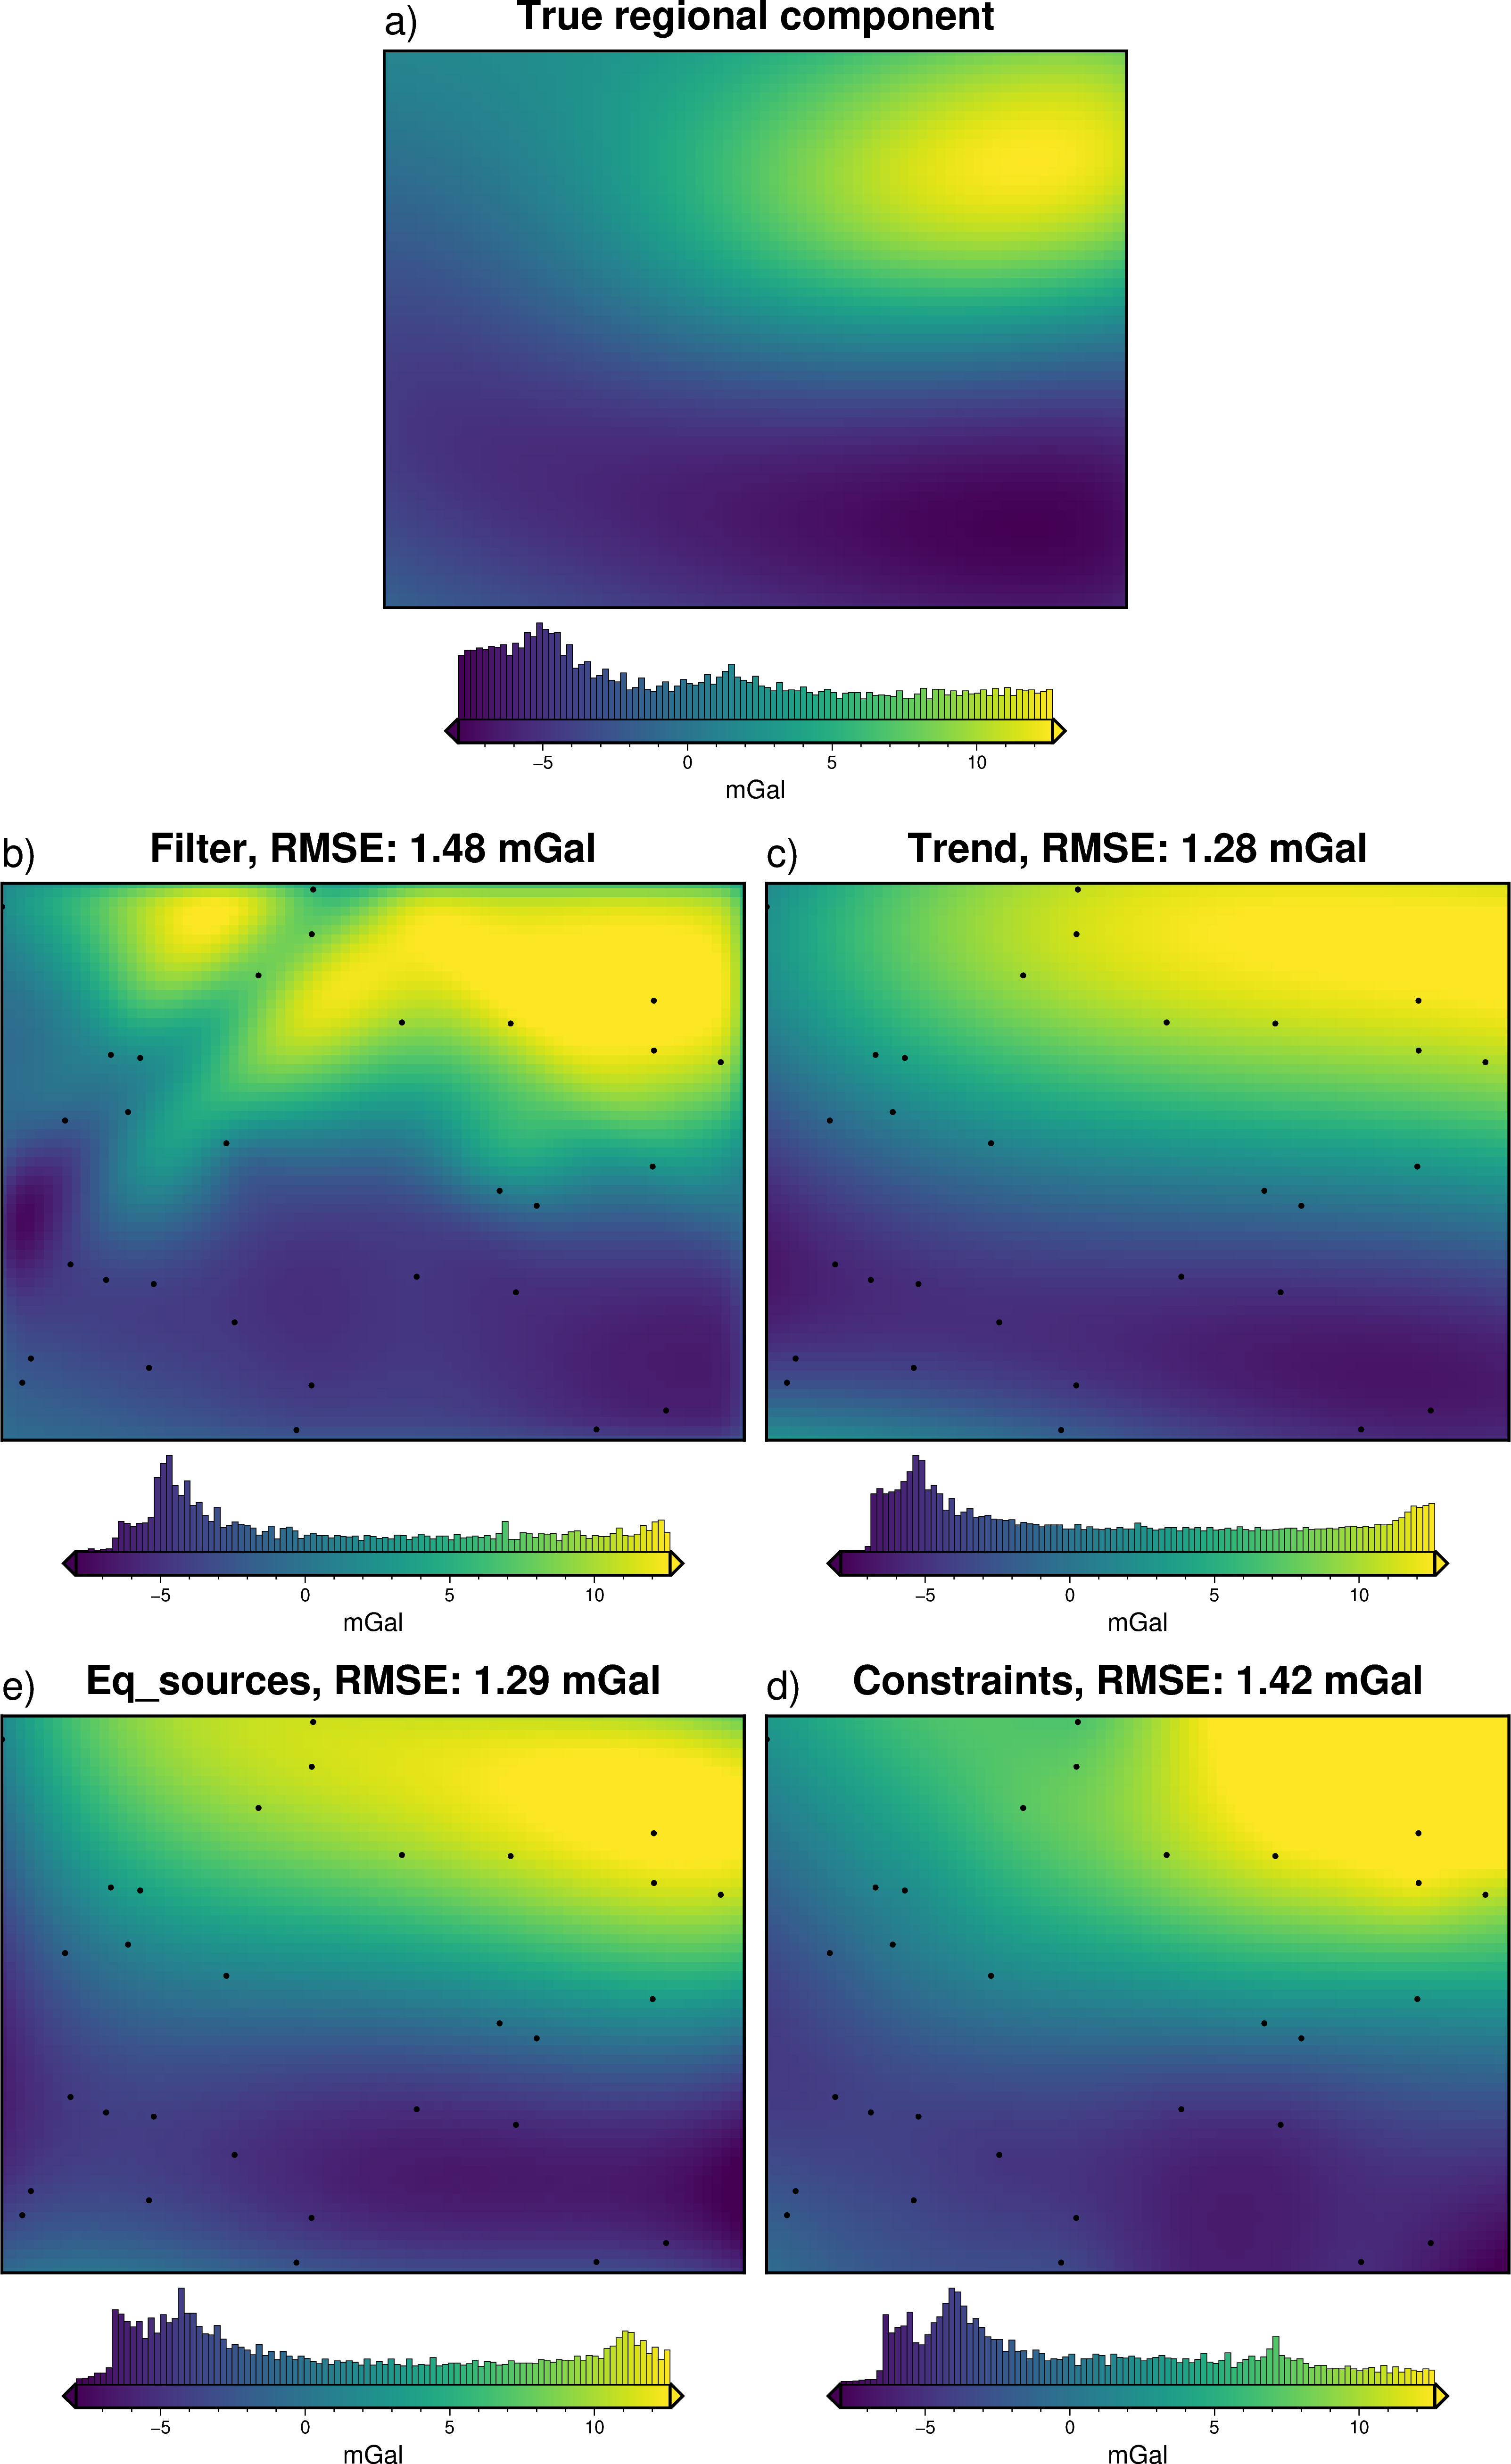

In [32]:
lims = utils.get_min_max(true_reg)

fig = maps.plot_grd(
    true_reg,
    fig_height=10,
    # cmap="vik",
    title="True regional component",
    region=inversion_region,
    hist=True,
    cbar_yoffset=2,
    cbar_label="mGal",  
    cpt_lims=lims,
)
fig.text(
    position="TL",
    justify="BL",
    text="a)",
    font="20p,Helvetica,black",
    offset="j0/.3",
    no_clip=True,
)

for i, g in enumerate(grids):
    if i == 0:
        origin_shift = "both_shift"
        xshift_amount = -.5
        yshift_amount = -1.15
    elif i == 1:
        origin_shift = "xshift"
        xshift_amount = 1
    elif i == 2:
        origin_shift = "yshift"
        yshift_amount = -1.15
    elif i == 3:
        origin_shift = "xshift"
        xshift_amount = -1
        
    fig = maps.plot_grd(
        g,
        points = constraint_points.rename(columns={"easting":"x","northing":"y"}),
        points_style = "c0.1c",
        fig=fig,
        fig_height=10,
        # cmap="vik",
        cpt_lims=lims,
        title=titles[i],
        region=inversion_region,
        hist=True,
        cbar_label="mGal",
        cbar_yoffset=2,
        origin_shift=origin_shift,
        xshift_amount=xshift_amount,
        yshift_amount=yshift_amount,
    )
    fig.text(
        position="TL",
        justify="BL",
        text=f"{string.ascii_lowercase[i+1]})",
        font="20p,Helvetica,black",
        offset="j0/.3",
        no_clip=True,
    )

fig.show()

In [ ]:
for i in methods:

    param = df[df[f"params_{i}"].notnull()].iloc[0][f"params_{i}"]

    df_anomalies = regional.regional_seperation(
        regional_method=i,
        filter=f"g{param}",
        trend=int(param),
        fill_method="pygmt",
        tension_factor=param,
        eq_sources=param,
        depth_type="relative",
        eq_damping=None,
        block_size=grav_spacing,
        **regional_kwargs,
    )

    _ = utils.grd_compare(
        regional_kwargs.get("true_regional"),
        df_anomalies.set_index(["northing","easting"]).to_xarray().reg,
        grid1_name="True regional gravity",
        grid2_name="Calculated regional gravity",
        title=f"Method: {i}",
        plot=True,
        region=inversion_region,
        plot_type="pygmt",
        cmap="vik",
        diff_cmap="vik+h0",
        hist=True,
        inset=False,
        points_style="c.15c",
        subplot_labels=True,
        # robust=True,
        robust=False,
        verbose="q",
        cbar_label="mGal",
    )

method: eq_sources, parameter: 2170000.0


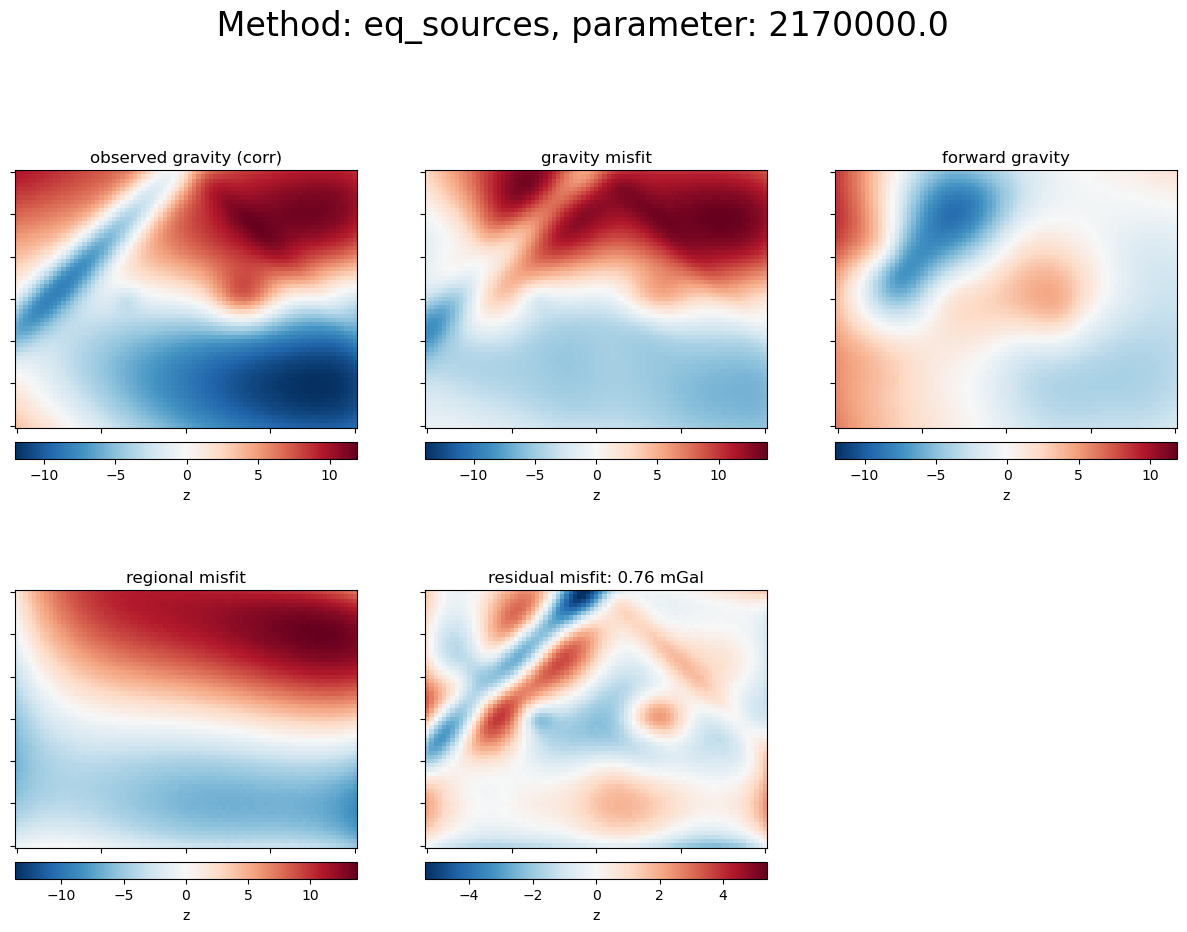

In [33]:
# choose the regional method:
# regional_method = "filter"
# regional_method = "trend"
# regional_method = "constraints"
regional_method = "eq_sources"

# set the parameter:
# param = .25

# get best param from chosen method.
param = df[df[f"params_{regional_method}"].notnull()].iloc[0][f"params_{regional_method}"]
print(f"method: {regional_method}, parameter: {param}")

df_anomalies = regional.regional_seperation(
    regional_method=regional_method,
    filter=f"g{param}",
    trend=int(param),
    fill_method="pygmt",
    tension_factor=param,
    eq_sources=param,
    depth_type="relative",
    eq_damping=None,
    block_size=grav_spacing,
    **regional_kwargs,
)

anom_grids = plotting.anomalies_plotting(
    df_anomalies,
    region=inversion_region,
    grav_spacing=grav_spacing,
    title=f" Method: {regional_method}, parameter: {param}",
    # constraints=constraint_points.rename(columns={"easting":"x","northing":"y"}),
    input_forward_column="layer1_forward",
    input_grav_column="Gobs",
    # plot_type="pygmt",
    plot_type="xarray",
    robust=False,
)

# _ = utils.grd_compare(
#     regional_kwargs.get("true_regional"),
#     df_anomalies.set_index(["northing","easting"]).to_xarray().reg,
#     grid1_name="True regional gravity",
#     grid2_name="Calculated regional gravity",
#     title=f"Method: {regional_method}",
#     plot=True,
#     region=kwargs.get("inversion_region"),
#     plot_type="pygmt",
#     cmap="vik",
#     diff_cmap="vik+h0",
#     hist=True,
#     inset=False,
#     points_style="c.15c",
#     subplot_labels=True,
#     # robust=True,
#     robust=False,
#     verbose="q",
#     cbar_label="mGal",
# )

## repeat with sampled grav and noise

In [ ]:
# contaminate with noise
sampled_grav_with_reg_noise = sampled_grav_with_reg.copy()
sampled_grav_with_reg_noise["Gobs"] = synthetic.contaminate(
    sampled_grav_with_reg_noise.Gobs,
    stddev=0.02,
    percent=True,
    seed=0,
)
# DC shift and calculate misfit
sampled_grav_with_reg_noise = inv.misfit(
    input_grav=sampled_grav_with_reg_noise,
    input_forward_column="layer1_forward",
    input_grav_column="Gobs",
    constraints=constraint_points,
)


In [ ]:
regional_kwargs = dict(
    input_grav=sampled_grav_with_reg,
    input_forward_column="layer1_forward",
    input_grav_column="Gobs_shift",
    grav_spacing=sampled_grav_spacing,
    inversion_region=inversion_region,
    true_regional=full_res_grav.set_index(["northing","easting"]).to_xarray().Surface2,
    constraints=constraint_points,
)

# set comparison method
# comparison_method='minimize_constraints'
comparison_method = "regional_comparison"

methods = ["filter", "trend", "constraints", "eq_sources"]

# for i in methods:
#     # set name and storage for the optimization
#     study_name = f"synthetic_simple_sampled_region_sep_indiv_{i}_{comparison_method}"
#     fname = f"../optimization_logs/{study_name}.log"
    
#     # remove if exists
#     # pathlib.Path(fname).unlink(missing_ok=True)

#     with warnings.catch_warnings():
#         warnings.filterwarnings("ignore", message="JournalStorage is experimental")
#         storage = JournalStorage(JournalFileStorage(fname))

#     # set number of runs per method
#     n_trials=20
    
#     # define search space if using GridSampler
#     # search_space = {
#     #     "damping": np.arange(-6, 1, step=2, dtype="float"),
#     #     # "weights_inner": np.arange(1e3, 1900, step=100),
#     #     "weights_outer": np.arange(2e3, 20e3, step=4e3, dtype="float"),
#     # }
#     # create study
#     with warnings.catch_warnings():
#         warnings.filterwarnings("ignore", message="BoTorch")
#         study = optuna.create_study(
#             study_name=study_name,
#             storage=storage,
#             direction="minimize",
#             # sampler=optuna.samplers.TPESampler(n_startup_trials=int(n_trials/3)),
#             sampler=optuna.integration.BoTorchSampler(n_startup_trials=int(n_trials/3)),
#             # sampler=optuna.samplers.GridSampler(search_space),
#             load_if_exists=True,
#             )

#     # define the objective function
#     objective = optimization.optimal_regional_params(
#         comparison_method = comparison_method,
#         regional_method = i,
#         filter_limits = [10e3, 500e3, 10e3], # 100 options
#         trend_limits = [1, 20, 1], # 20 options
#         constraints_limits = [0, 1, 0.01], # 101 options
#         eq_sources_limits = [10e3, 5000e3, 10e3], # 1000 options
#         **regional_kwargs)

#     # run the optimization
#     with inv_utils.HiddenPrints():
#         with warnings.catch_warnings():
#             warnings.simplefilter("ignore")
#             study, study_df = optimization.optuna_parallel(
#                 study_name=study_name,
#                 study_storage=storage,
#                 objective=objective,
#                 n_trials=n_trials,
#                 maximize_cpus=True,
#                 parallel=True,
#             )

# load studies
study_dfs = []
for i in methods:
    study_name = f"synthetic_simple_sampled_region_sep_indiv_{i}_{comparison_method}"
    fname = f"../optimization_logs/{study_name}.log"
        
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message="JournalStorage is experimental")
        storage = JournalStorage(JournalFileStorage(fname))
        
    study = optuna.load_study(storage=storage, study_name=study_name)
    study_df = study.trials_dataframe()
    study_dfs.append(study_df)

    # plot results
    # plotting.plot_best_param(
    #     study_df, comparison_method, regional_method=i, **regional_kwargs
    # )
    # optuna.visualization.plot_slice(study).show()

studies = dict(zip(methods, study_dfs))

for k, v in studies.items():
    v["params_method"] = k

regional_sep_combined_studies = pd.concat(
    studies.values(), ignore_index=True
).sort_values(by="value")

In [ ]:
df = regional_sep_combined_studies
df.head()

In [ ]:
best_filter = df[df.params_method == "filter"].iloc[0].number
best_trend = df[df.params_method == "trend"].iloc[0].number
best_constraints = df[df.params_method == "constraints"].iloc[0].number
best_eq_sources = df[df.params_method == "eq_sources"].iloc[0].number

print(f"best filter: index {best_filter}")
print(f"best trend: index {best_trend}")
print(f"best constraints: index {best_constraints}")
print(f"best eq sources: index {best_eq_sources}")

In [ ]:
regional_method = df.iloc[0].params_method
print(f"best method: {regional_method}")

param = df[df[f"params_{regional_method}"].notnull()].iloc[0][
    f"params_{regional_method}"
]
print(f"best parameter: {param}")

In [ ]:
# choose the regional method:
# regional_method = "filter"
# regional_method = "trend"
# regional_method = "constraints"
# regional_method = "eq_sources"

# set the parameter:
# param = .25

# get best param from chosen method.
param = df[df[f"params_{regional_method}"].notnull()].iloc[0][
    f"params_{regional_method}"
]

df_anomalies_sampled = regional.regional_seperation(
    regional_method=regional_method,
    filter=f"g{param}",
    trend=param,
    fill_method="pygmt",
    tension_factor=param,
    eq_sources=param,
    depth_type="relative",
    eq_damping=None,
    block_size=sampled_grav_spacing,
    **regional_kwargs,
)

# anom_grids = plotting.anomalies_plotting(
#     df_anomalies_sampled,
#     region=inversion_region,
#     grav_spacing=sampled_grav_spacing,
#     title=f" Method: {regional_method}, parameter: {param}",
#     constraints=constraint_points.rename(columns={"easting":"x","northing":"y"}),
#     input_forward_column="layer1_forward",
#     input_grav_column="Gobs",
#     plot_type="pygmt",
#     robust=False,
# )

# _ = utils.grd_compare(
#     regional_kwargs.get("true_regional"),
#     df_anomalies.set_index(["northing","easting"]).to_xarray().reg,
#     grid1_name="True regional gravity",
#     grid2_name="Calculated regional gravity",
#     title=f"Method: {regional_method}",
#     plot=True,
#     region=kwargs.get("inversion_region"),
#     plot_type="pygmt",
#     cmap="vik",
#     diff_cmap="vik+h0",
#     hist=True,
#     inset=False,
#     points_style="c.15c",
#     subplot_labels=True,
#     # robust=True,
#     robust=False,
#     verbose="q",
#     cbar_label="mGal",
# )

## Plot inversion inputs

In [ ]:
# residual = df_anomalies.set_index(["northing", "easting"]).to_xarray().res
# # residual.plot(robust=True)

# # plot residual misfit
# fig = maps.plot_grd(
#     grid=residual,
#     fig_height=8,
#     cmap="vik+h0",
#     region=buffer_region,
#     title="Residual Misfit",
#     cbar_unit="mGal",
#     show_region=inversion_region,
#     points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
#     points_style="c0.1c",
#     hist=True,
#     cbar_yoffset=3,
# )
# fig.text(
#     position="TL",
#     justify="BL",
#     text="a)",
#     font="26p,Helvetica,black",
#     offset="j0/.3",
#     no_clip=True,
# )

# # plot layer 2
# fig = maps.plot_grd(
#     grid=starting_layer1,
#     fig_height=8,
#     cmap="rain",
#     reverse_cpt=True,
#     region=buffer_region,
#     grd2cpt=True,
#     title="Starting Surface 1",
#     cbar_label="elevation",
#     cbar_unit="m",
#     show_region=inversion_region,
#     hist=True,
#     cbar_yoffset=3,
#     fig=fig,
#     origin_shift="xshift",
#     points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
#     points_style="c0.1c",
# )
# fig.text(
#     position="TL",
#     justify="BL",
#     text="b)",
#     font="26p,Helvetica,black",
#     offset="j0/.3",
#     no_clip=True,
# )

# fig.show()

# Inversion

Now that we have $G_{misfit}$, we can run an inversion to attempt to recover the true Layer 2 topography. Theres a number of parameters to choose from for the inversion.

In [ ]:
# # set kwargs for inversion
# kwargs = dict(
#     input_grav_column="Gobs_shift",
#     prism_layer=starting_prisms,
#     max_iterations=200,
#     l2_norm_tolerance=0.01,
#     delta_l2_norm_tolerance=1.01, # stop if l2-norm doesnt decrease by at least 1%
#     # apply_weights = True,
#     weights_after_solving = True,
#     deriv_type = "annulus",
#     solver_type = "scipy least squares",
#     solver_damping = 10**-3,   
# )

# results = inv.inversion_RMSE(
    
#     input_grav=df_anomalies,
#     # input_grav=df_anomalies_sampled,

#     inversion_region=inversion_region,
#     true_surface = layer1,
#     constraints=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
#     plot=True,
#     plot_type="xarray",
#     **kwargs,
# )

# (
#     rmse,
#     prism_results,
#     grav_results,
#     params,
#     elapsed_time,
#     constraints_rmse,
# ) = results

# _ = plotting.plot_inversion_results(
#         grav_results,
#         prism_results,
#         params,
#         grav_region=inversion_region,
#         plot_iter_results=True,
#         plot_topo_results=True,
#         plot_grav_results=True,
#         iters_to_plot=4,
    
#         grav_spacing=grav_spacing,
#         # grav_spacing=sampled_grav_spacing,
    
#         constraints=constraint_points,
#     )

# print(f"RMSE: {rmse}")
# print(f"constraints RMSE: {constraints_rmse}")

## Optimize the inversion

To determine optimal inversion parameters, we will run an optimization routine which minimizes the root median square error (RMSE) of the ending Surface 2 to the true Surface 2. 

The parameters we will test are:
* Solver damping

In [34]:

# set kwargs for inversion
kwargs = dict(
    input_grav=df_anomalies,
    input_grav_column="Gobs_shift",
    # prism_layer=starting_prisms,
    inversion_region=inversion_region,
    max_iterations=100,
    l2_norm_tolerance=0.01,
    delta_l2_norm_tolerance=1.005, # stop if l2-norm doesnt decrease by at least 1%
    # apply_weights = True,
    weights_after_solving = True,
    deriv_type = "annulus",
    solver_type = "scipy least squares",
)

# set name and storage for the optimization
# study_name = "synthetic_simple_inversion_damping_weights_constraints"
study_name = "synthetic_simple_inversion_damping_weights_eq_sources"
# study_name = "synthetic_simple_inversion_damping_weights_trend"

fname = f"../optimization_logs/{study_name}.log"

# remove if exists
pathlib.Path(fname).unlink(missing_ok=True)
pathlib.Path(f"{fname}.lock").unlink(missing_ok=True)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="JournalStorage is experimental")
    storage = JournalStorage(JournalFileStorage(fname))


In [ ]:
utils.

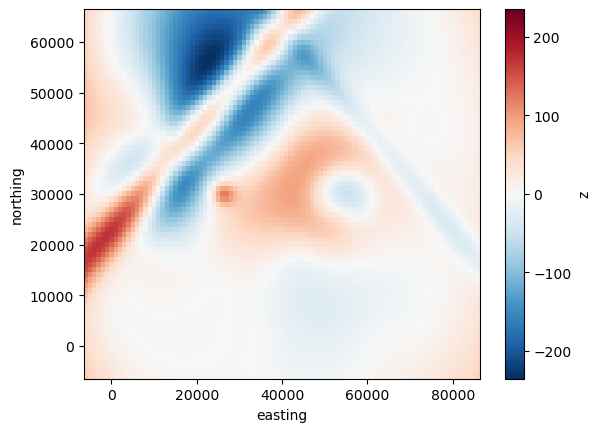

In [48]:
(starting_layer1-layer1).plot()

In [37]:
# set number of runs
n_trials = 20

# set objectives
objectives = [
    "RMSE"
    # "duration"
    # "constraints"
]

# set directions
directions = [
    "minimize"
    # "minimize"
    # "minimize"
]

# define search space if using GridSampler
# search_space = {
#     "damping": np.arange(-6, 1, step=1, dtype="float"),
#     # "weights_inner": np.arange(1e3, 1900, step=100),
#     "weights_outer": np.arange(2e3, 20e3, step=2e3, dtype="float"),
# }
# create study
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="BoTorch")
    study = optuna.create_study(
        study_name=study_name,
        storage=storage,
        directions=directions,
        # sampler=optuna.samplers.TPESampler(n_startup_trials=int(n_trials/3)),
        sampler=optuna.integration.BoTorchSampler(n_startup_trials=int(n_trials/3)),
        # sampler=optuna.samplers.GridSampler(search_space),
        load_if_exists=True,
        )

# define the objective function
objective_func = optimization.optimal_inversion_damping_and_weights(
    layer1,
    damping_limits = [-4, 2], # damping = 10^damping_limit
    weights_inner_limits = [layer_spacing],
    weights_outer_limits = [layer_spacing+1e3, 20e3],
    weights_step = 100,
    starting_prisms = starting_prisms,
    objectives = objectives,
    constraints = constraint_points,
    **kwargs)

# objective_func = optimization.optimal_inversion_damping(
#     layer1,
#     damping_limits = [-10, 1], # damping = 10^damping_limit
#     objectives = objectives,
#     constraints = constraint_points,
#     **kwargs)

# run the optimization
with inv_utils.HiddenPrints():
    study, study_df = optimization.optuna_parallel(
        study_name=study_name,
        study_storage=storage,
        objective = objective_func,
        n_trials=n_trials,
        maximize_cpus=True,
        parallel=True,
    )

[I 2023-04-19 18:00:14,604] A new study created in Journal with name: synthetic_simple_inversion_damping_weights_eq_sources


Optimizing:   0%|          | 0/20 [00:00<?, ?it/s]

In [38]:
# load and plot past study
study = optuna.load_study(
    study_name=study_name,
    storage=storage,
)
print(study.best_trial)
plotting.plot_optuna_inversion_figures(
    study,
    target_names=objectives,
    # include_duration=True,
)

FrozenTrial(number=8, state=TrialState.COMPLETE, values=[18.876659806233988], datetime_start=datetime.datetime(2023, 4, 19, 18, 0, 31, 215115), datetime_complete=datetime.datetime(2023, 4, 19, 18, 1, 1, 320068), params={'damping': 0, 'weights_outer': 7100}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'damping': IntDistribution(high=2, log=False, low=-4, step=1), 'weights_outer': IntDistribution(high=20000, log=False, low=2000, step=100)}, trial_id=8, value=None)


In [46]:
study.trials_dataframe().sort_values("value")[0:10]

number      value             datetime_start          datetime_complete  \
8        8  18.876660 2023-04-19 18:00:31.215115 2023-04-19 18:01:01.320068   
0        0  18.909265 2023-04-19 18:00:29.131651 2023-04-19 18:00:43.045918   
4        4  18.909265 2023-04-19 18:00:32.921209 2023-04-19 18:00:53.116185   
14      14  18.909265 2023-04-19 18:00:31.450792 2023-04-19 18:01:16.010024   
5        5  18.916733 2023-04-19 18:00:33.525411 2023-04-19 18:00:51.401321   
13      13  18.916733 2023-04-19 18:00:34.752654 2023-04-19 18:01:15.421493   
15      15  18.916733 2023-04-19 18:00:33.984154 2023-04-19 18:01:17.986787   
11      11  18.916736 2023-04-19 18:00:32.075280 2023-04-19 18:01:08.330942   
10      10  18.916736 2023-04-19 18:00:35.092748 2023-04-19 18:01:06.206336   
7        7  18.916736 2023-04-19 18:00:34.379237 2023-04-19 18:00:59.886962   

                 duration  params_damping  params_weights_outer     state  
8  0 days 00:00:30.104953               0                  7100  COMPLETE  
0  0 days 00:00:13.914267              -1                 19300  COMPLETE  
4  0 days 00:00:20.194976              -1                 18000  COMPLETE  
14 0 days 00:00:44.559232              -1                 19500  COMPLETE  
5  0 days 00:00:17.875910               0                 18900  COMPLETE  
13 0 days 00:00:40.668839               1                 12600  COMPLETE  
15 0 days 00:00:44.002633               2                  2100  COMPLETE  
11 0 days 00:00:36.255662               1                  3100  COMPLETE  
10 0 days 00:00:31.113588               1                  5100  COMPLETE  
7  0 days 00:00:25.507725               1                  5600  COMPLETE

In [42]:
df = study.trials_dataframe().sort_values(by="value").iloc[1]
params = {'damping': df.params_damping.item(), 'weights_outer':  df.params_weights_outer}

# params = study.best_params
params

{'damping': -1, 'weights_outer': 19300}

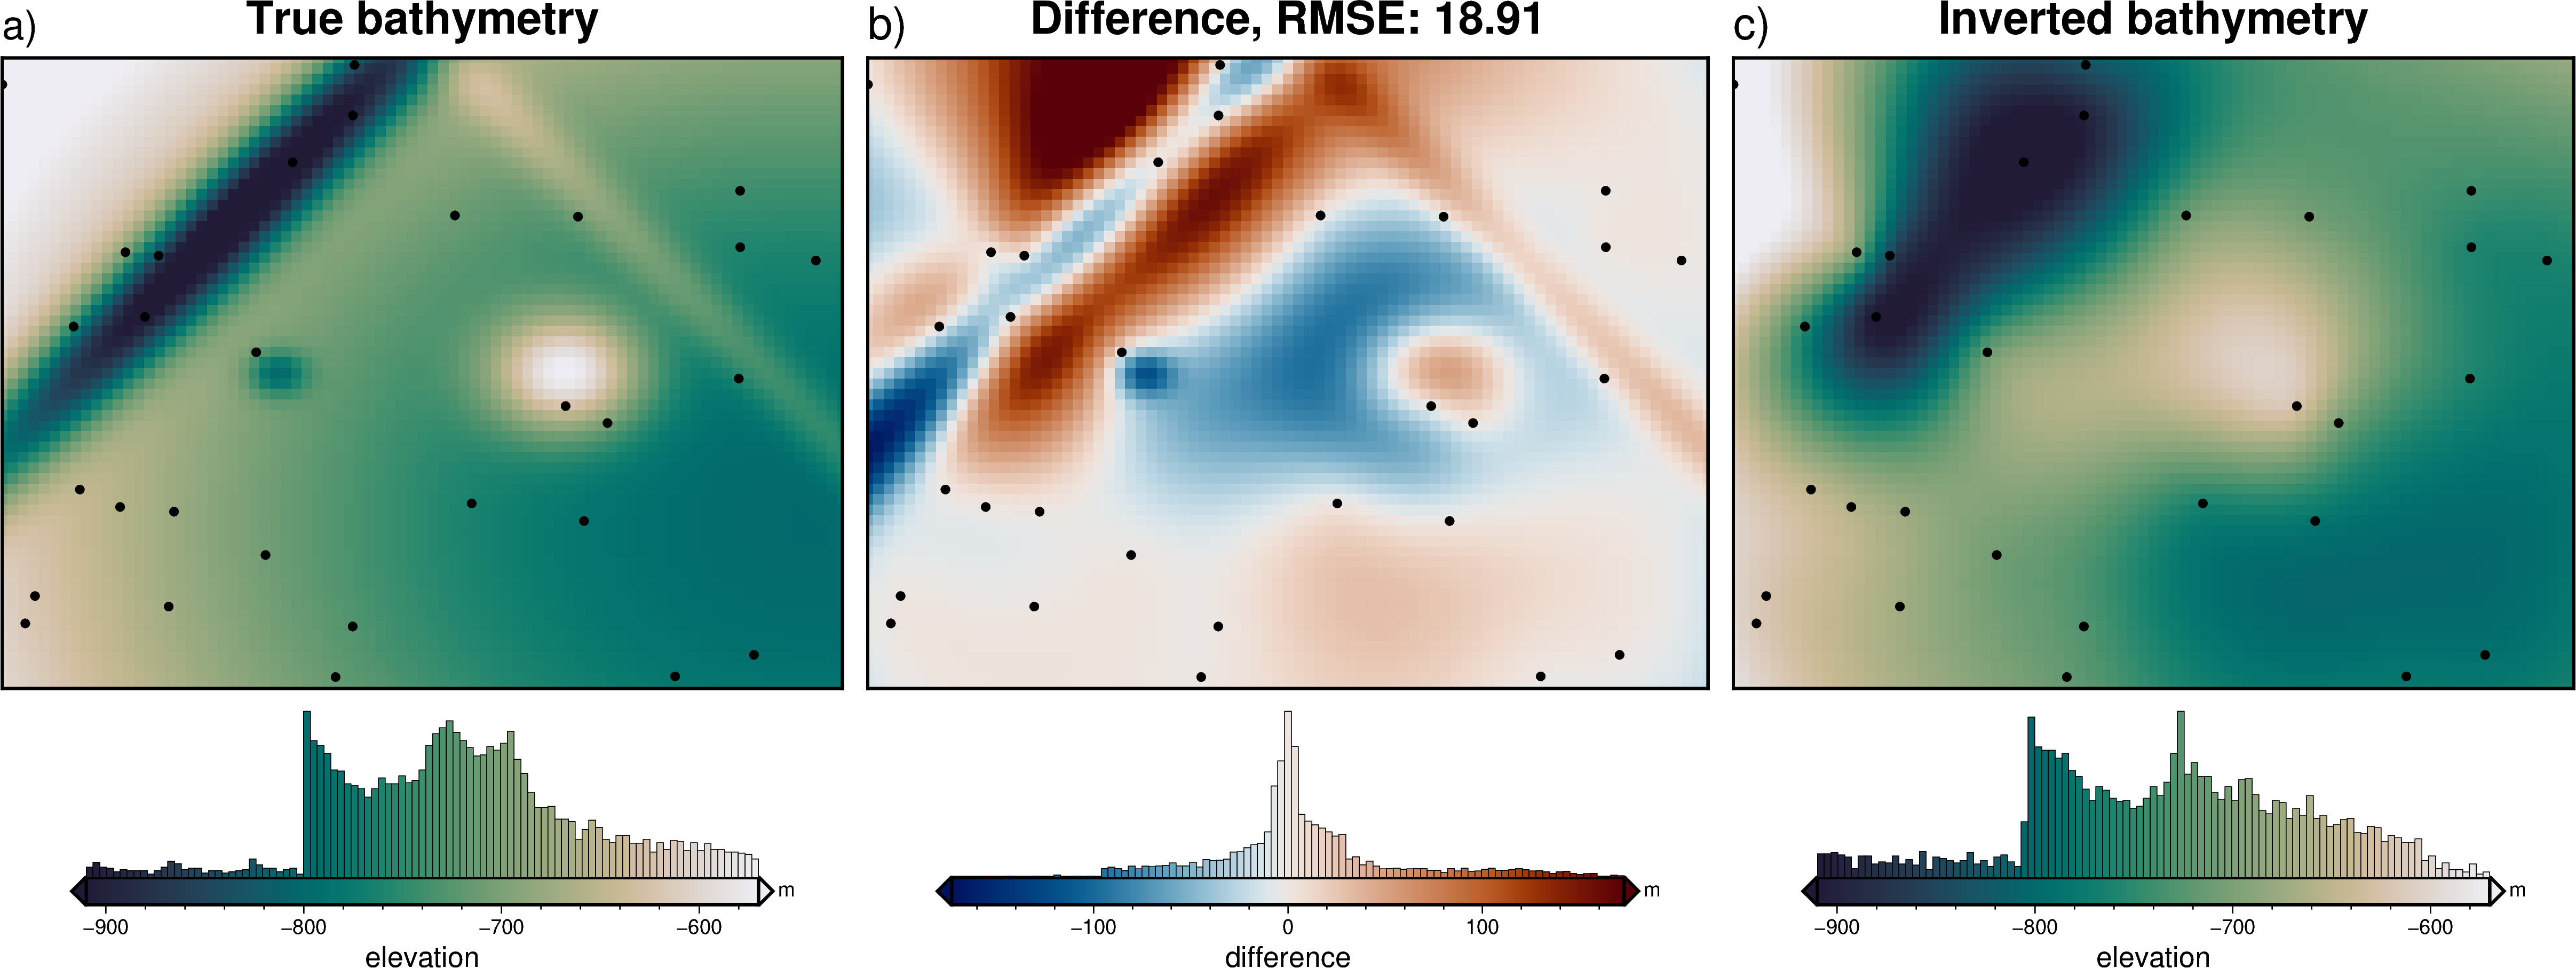

RMSE between surfaces at constraints: 0.04 m


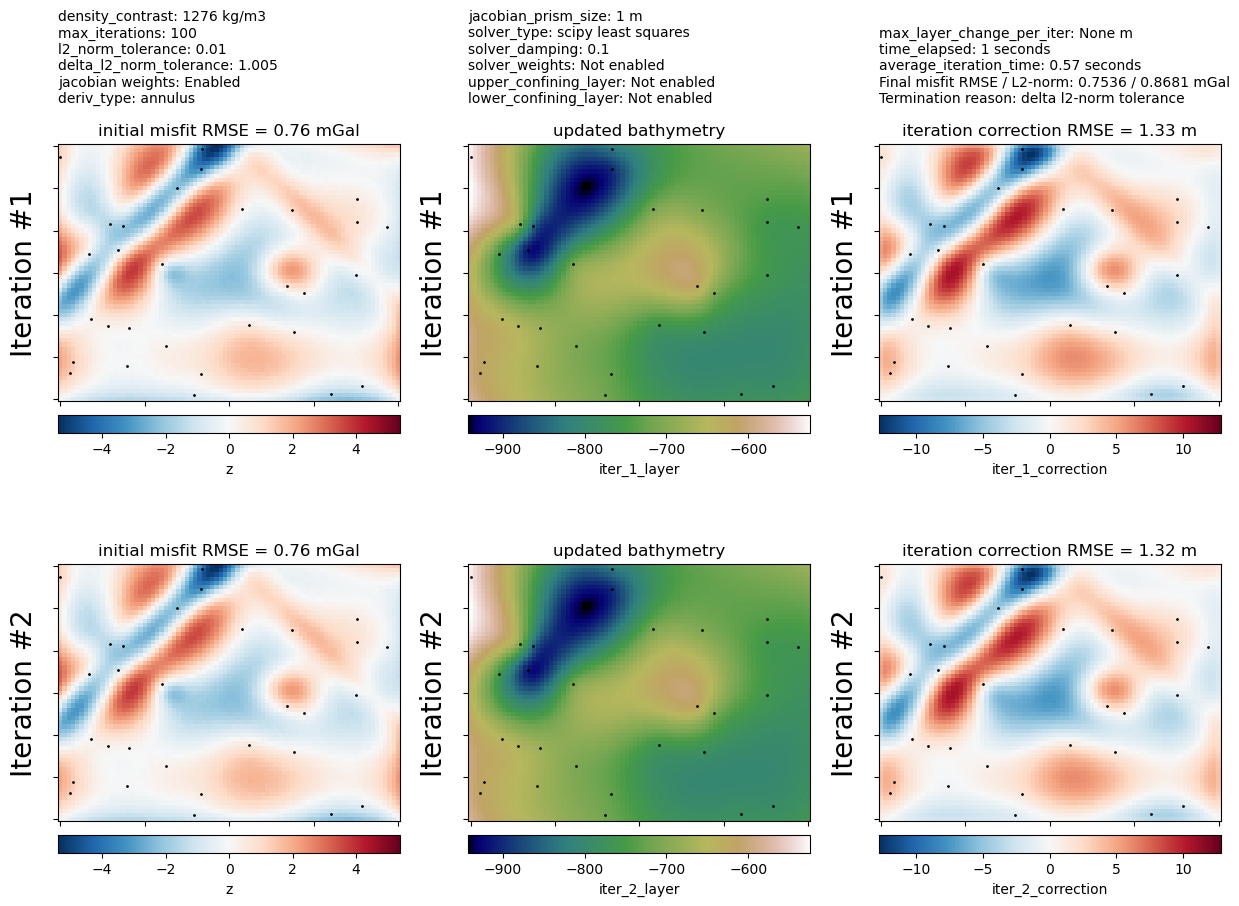

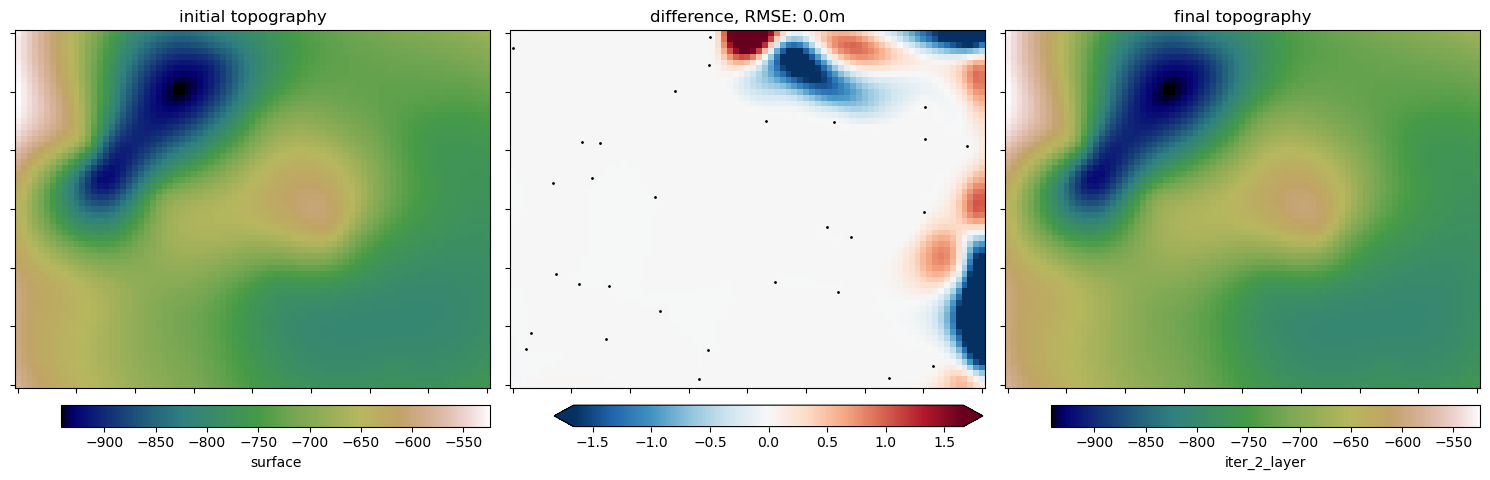

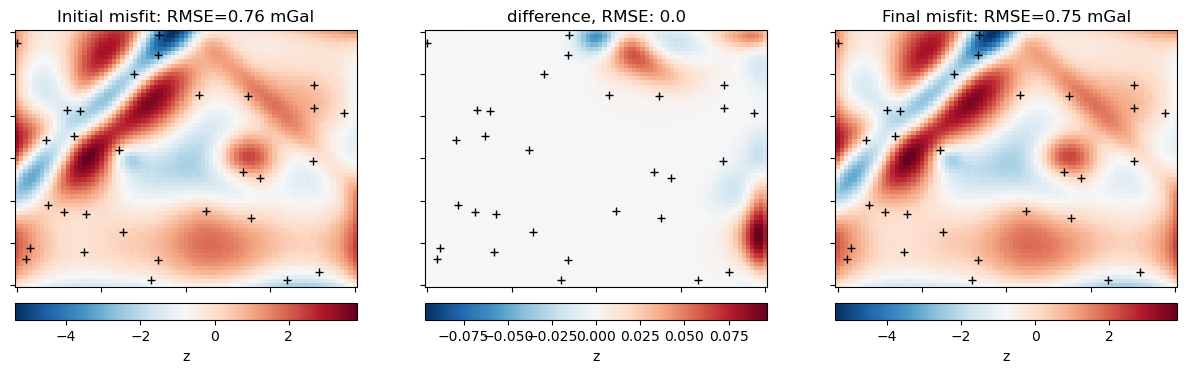

In [43]:
weights, _ = inv_utils.constraints_grid(
    constraint_points,  
    starting_prisms.drop("weights"),
    inner_bound = layer_spacing, 
    outer_bound = params['weights_outer'],
    low = 0,
    high = 1,
    region = inversion_region,
    interp_type = "spline",
)
weights.plot()     
starting_prisms["weights"] = weights
        
plotting.plot_best_inversion(
    true_surface=layer1,
    prism_layer = starting_prisms,
    best_params = params,
    grav_spacing = grav_spacing,
    constraint_points = constraint_points,
    plot_type = "pygmt",
    robust = True,
    **kwargs
)

## Repeat with sampled data and noise

In [ ]:
# set kwargs for inversion
kwargs = dict(
    input_grav=df_anomalies_sampled,
    input_grav_column="Gobs_shift",
    # prism_layer=starting_prisms,
    inversion_region=inversion_region,
    max_iterations=200,
    l2_norm_tolerance=0.01,
    delta_l2_norm_tolerance=1.01, # stop if l2-norm doesnt decrease by at least 1%
    # apply_weights = True,
    weights_after_solving = True,
    deriv_type = "annulus",
    solver_type = "scipy least squares",
)

# set name and storage for the optimization
study_name = "synthetic_simple_sampled_inversion_damping_weights"
fname = f"../optimization_logs/{study_name}.log"

# remove if exists
# pathlib.Path(fname).unlink(missing_ok=True)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="JournalStorage is experimental")
    storage = JournalStorage(JournalFileStorage(fname))

In [ ]:
# set number of runs
n_trials = 50

# set objectives
objectives = [
    "RMSE"
    # "duration"
    # "constraints"
]

# set directions
directions = [
    "minimize"
    # "minimize"
    # "minimize"
]

# define search space if using GridSampler
search_space = {
    "damping": np.arange(-6, 1, step=1, dtype="float"),
    # "weights_inner": np.arange(1e3, 1900, step=100),
    "weights_outer": np.arange(2e3, 20e3, step=2e3, dtype="float"),
}
# create study
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="BoTorch")
    study = optuna.create_study(
        study_name=study_name,
        storage=storage,
        directions=directions,
        # sampler=optuna.samplers.TPESampler(n_startup_trials=int(n_trials/3)),
        # sampler=optuna.integration.BoTorchSampler(n_startup_trials=int(n_trials/3)),
        sampler=optuna.samplers.GridSampler(search_space),
        load_if_exists=True,
        )

# define the objective function
objective_func = optimization.optimal_inversion_damping_and_weights(
    layer1,
    damping_limits = [-6, 1], # damping = 10^damping_limit
    weights_inner_limits = [1e3],#[1e3, 1900],
    weights_outer_limits = [2e3, 15e3],
    weights_step = 100,
    starting_prisms = starting_prisms,
    objectives = objectives,
    constraints = constraint_points,
    **kwargs)

# objective_func = optimization.optimal_inversion_damping(
#     layer1,
#     damping_limits = [-10, 1], # damping = 10^damping_limit
#     objectives = objectives,
#     constraints = constraint_points,
#     **kwargs)

# run the optimization
# with inv_utils.HiddenPrints():
#     study, study_df = optimization.optuna_parallel(
#         study_name=study_name,
#         study_storage=storage,
#         objective = objective_func,
#         n_trials=n_trials,
#         maximize_cpus=True,
#         parallel=True,
#         # parallel=False,
#     )
    

In [ ]:
# load and plot past study
study = optuna.load_study(
    study_name=study_name,
    storage=storage,
)

print(study.best_trial)
plotting.plot_optuna_inversion_figures(
    study,
    target_names=objectives,
    # include_duration=True,
)

In [ ]:
weights, _ = inv_utils.constraints_grid(
    constraint_points,  
    starting_prisms.drop("weights"),
    inner_bound=1e3, #study.best_params['weights_inner'],
    outer_bound=study.best_params['weights_outer'],
    low=0,
    high=1,
    # region=inversion_region,
    interp_type="spline",
)
        
starting_prisms["weights"] = weights
        
plotting.plot_best_inversion(
    true_surface=layer1,
    prism_layer = starting_prisms,
    best_params=study.best_params,
    grav_spacing=sampled_grav_spacing,
    constraint_points=constraint_points,
    plot_type="pygmt",
    **kwargs
)

# Repeat with noise

The above inversion was able to fully recover Layer 2. This is expected, since there was no noise in the data, and we used a very simple 2 layer model to create the observed gravity. Next we add 2% gaussian noise to $G_{misfit}$ to see how the inversion performs.

In [ ]:
# df_anomalies_noise = df_anomalies.copy()

# df_anomalies_noise["res"] = synthetic.contaminate(
#     df_anomalies_noise.res,
#     stddev=0.02,
#     percent=True,
#     seed=0,
# )
# df_anomalies_noise

# Repeat with synthetic survey